In [1]:
# Author: Tiago Tamagusko (tamagusko@gmail.com)
# Version: 3.0 (2022-11-15)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import pickle
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from sklearn.model_selection import train_test_split

%matplotlib inline

# improve quality of images
plt.rcParams['figure.dpi'] = 400
plt.rcParams['savefig.dpi'] = 400
sns.set(rc={"figure.dpi":400, 'savefig.dpi':400})
sns.set_context('notebook')
sns.set_style("ticks")

In [3]:
# Regressors
DT_reg = DecisionTreeRegressor(random_state=42, max_depth=10)
RF_reg = RandomForestRegressor(random_state=42, max_depth=10)
XG_reg = xgb.XGBRegressor(random_state=42, max_depth=4)

In [4]:
# Data

IRI = pd.read_csv('data/raw/iri.csv')
TRAFFIC = pd.read_csv('data/raw/aadtt.csv')
SN = pd.read_csv('data/raw/sn.csv')
PREC = pd.read_csv('data/raw/precipitation.csv')
TEMP = pd.read_csv('data/raw/temperature.csv')

In [5]:
# Cleaning data
IRI = IRI[['STATE_CODE', 'SHRP_ID', 'VISIT_DATE', 'MRI']]
TRAFFIC = TRAFFIC[['STATE_CODE', 'SHRP_ID', 'YEAR', 'AADTT_ALL_TRUCKS_TREND']]
SN = SN[['STATE_CODE', 'SHRP_ID', 'SN_VALUE']]
PREC = PREC.drop(['STATE_CODE_EXP', 'TOTAL_SNOWFALL_YR'], axis=1)
TEMP = TEMP.drop(['STATE_CODE_EXP', 'FREEZE_THAW_YR', 'FREEZE_INDEX_YR'], axis=1)

IRI['VISIT_DATE'] = pd.DatetimeIndex(IRI['VISIT_DATE']).year
IRI.rename(columns={'VISIT_DATE': 'YEAR'}, inplace=True)

In [6]:
# Processing climate data
CLIMATE = pd.merge(PREC, TEMP, on=[
                   'SHRP_ID', 'STATE_CODE', 'YEAR', 'VWS_ID']).drop(['VWS_ID'], axis=1)
# Processing data
DATA = pd.merge(IRI, CLIMATE, how='right', on=[
                'SHRP_ID', 'STATE_CODE', 'YEAR'])
DATA = pd.merge(DATA, TRAFFIC, how='right', on=[
                'SHRP_ID', 'STATE_CODE', 'YEAR'])
DATA = pd.merge(DATA, SN, how='right', on=['SHRP_ID', 'STATE_CODE'])
DATA.shape

(3166, 8)

In [7]:
# drop NA and duplicates
DATA = DATA.dropna()
DATA = DATA.drop_duplicates()
DATA.shape

(2203, 8)

In [8]:
# Sort dataset
DATA = DATA.sort_values(['YEAR'], ascending=[True])

In [9]:
# Drop unused columns
DATA = DATA.drop(['STATE_CODE', 'SHRP_ID'], axis=1)
# Rename columns
DATA = DATA.rename({'YEAR': 'Year',
                    'MRI': 'IRI',
                    'TOTAL_ANN_PRECIP': 'Precipitation',
                    'MEAN_ANN_TEMP_AVG': 'Temperature',
                    'AADTT_ALL_TRUCKS_TREND': 'AADTT',
                    'SN_VALUE': 'SN',
                    }, axis=1)

In [10]:
DATA.head()

Year    IRI  Precipitation  Temperature  AADTT   SN
773   1989  0.896     434.000000         15.1    520  4.7
1181  1989  0.869    1403.699951          4.4    195  2.8
1182  1989  0.850    1403.699951          4.4    195  2.8
1183  1989  0.861    1403.699951          4.4    195  2.8
1106  1989  1.765    1177.500000          5.1    586  2.8

In [11]:
DATA.describe().T

count         mean         std          min          25%  \
Year           2203.0  1995.877440    5.106269  1989.000000  1992.000000   
IRI            2203.0     1.341840    0.559245     0.606000     0.924000   
Precipitation  2203.0  1009.588246  449.602270    92.199997   714.900024   
Temperature    2203.0    13.833227    5.601459     2.700000     7.900000   
AADTT          2203.0   452.120744  528.140744     4.000000   142.000000   
SN             2203.0     4.160236    1.476863     1.100000     2.800000   

                       50%          75%       max  
Year           1995.000000  1999.000000  2017.000  
IRI               1.196000     1.606500     4.095  
Precipitation  1060.800049  1333.800049  2091.000  
Temperature      15.300000    17.500000    25.900  
AADTT           262.000000   526.000000  3126.000  
SN                4.200000     5.300000     8.000

In [12]:
# verify data
DATA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2203 entries, 773 to 1832
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Year           2203 non-null   int64  
 1   IRI            2203 non-null   float64
 2   Precipitation  2203 non-null   float64
 3   Temperature    2203 non-null   float64
 4   AADTT          2203 non-null   int64  
 5   SN             2203 non-null   float64
dtypes: float64(4), int64(2)
memory usage: 120.5 KB


In [13]:
# Save processed data
DATA.to_csv('data/processed/ltpp-data.csv', index=None, header=True)

In [14]:
# Split into target and dataset
y = DATA['IRI']  # target
X = DATA.drop(['IRI'], axis=1)

In [15]:
X.shape, y.shape

((2203, 5), (2203,))

In [16]:
# Split in 75/25 (train/test)
train_threshold = 0.75

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_threshold, random_state=0)

In [17]:
# Train models
DT_reg.fit(X_train, y_train)
RF_reg.fit(X_train, y_train)
XG_reg.fit(X_train, y_train)
print('Data trained! =)')

Data trained! =)


In [18]:
# Predict results
resultDT = DT_reg.predict(X_test)
resultRF = RF_reg.predict(X_test)
resultXG = XG_reg.predict(X_test)
print('Predicted! =)')

Predicted! =)


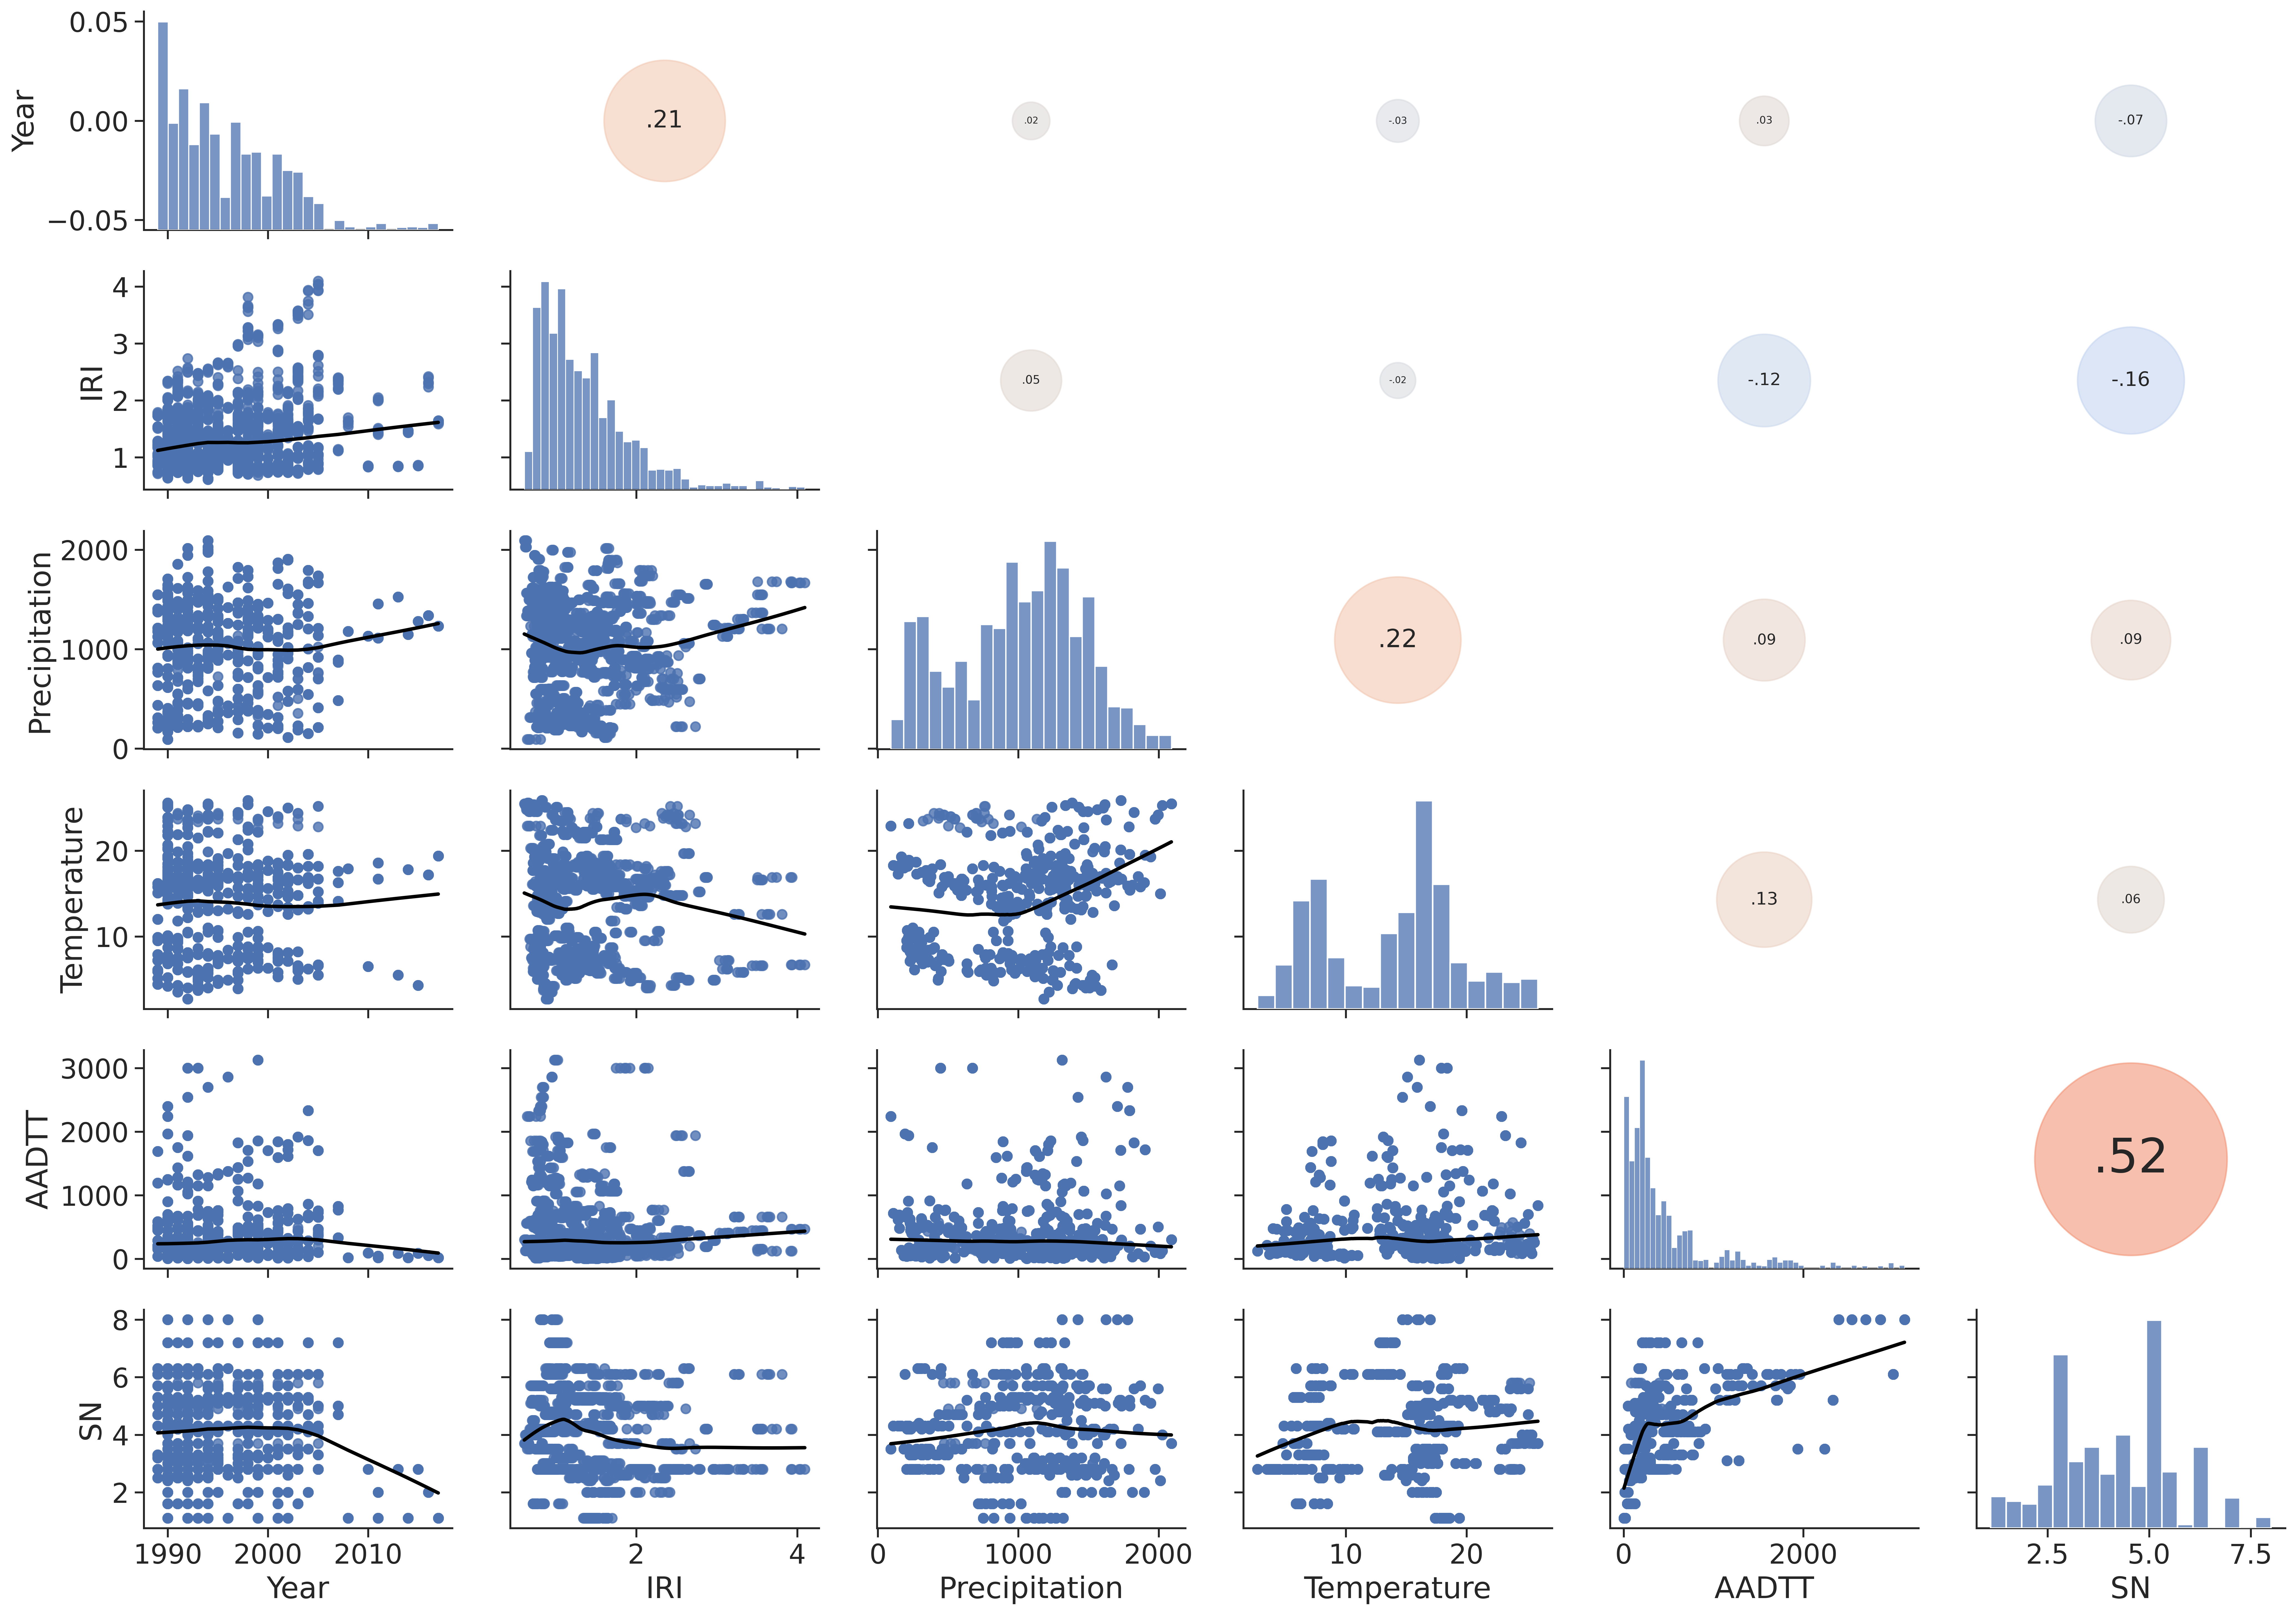

In [19]:
def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca()
    ax.set_axis_off()
    marker_size = abs(corr_r) * 30000
    ax.scatter([.5], [.5], marker_size, [corr_r], alpha=0.6, cmap="coolwarm",
               vmin=-1, vmax=1, transform=ax.transAxes)
    font_size = abs(corr_r) * 50 + 5
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)

sns.set(style='ticks', font_scale=1.6)

g = sns.PairGrid(DATA, aspect=1.4, diag_sharey=False)
g.map_lower(sns.regplot, lowess=True, ci=False, line_kws={'color': 'black'})
g.map_diag(sns.histplot, kde_kws={'color': 'black'})
g.map_upper(corrdot)
g.savefig('results/scatter_matrixSNS.png')

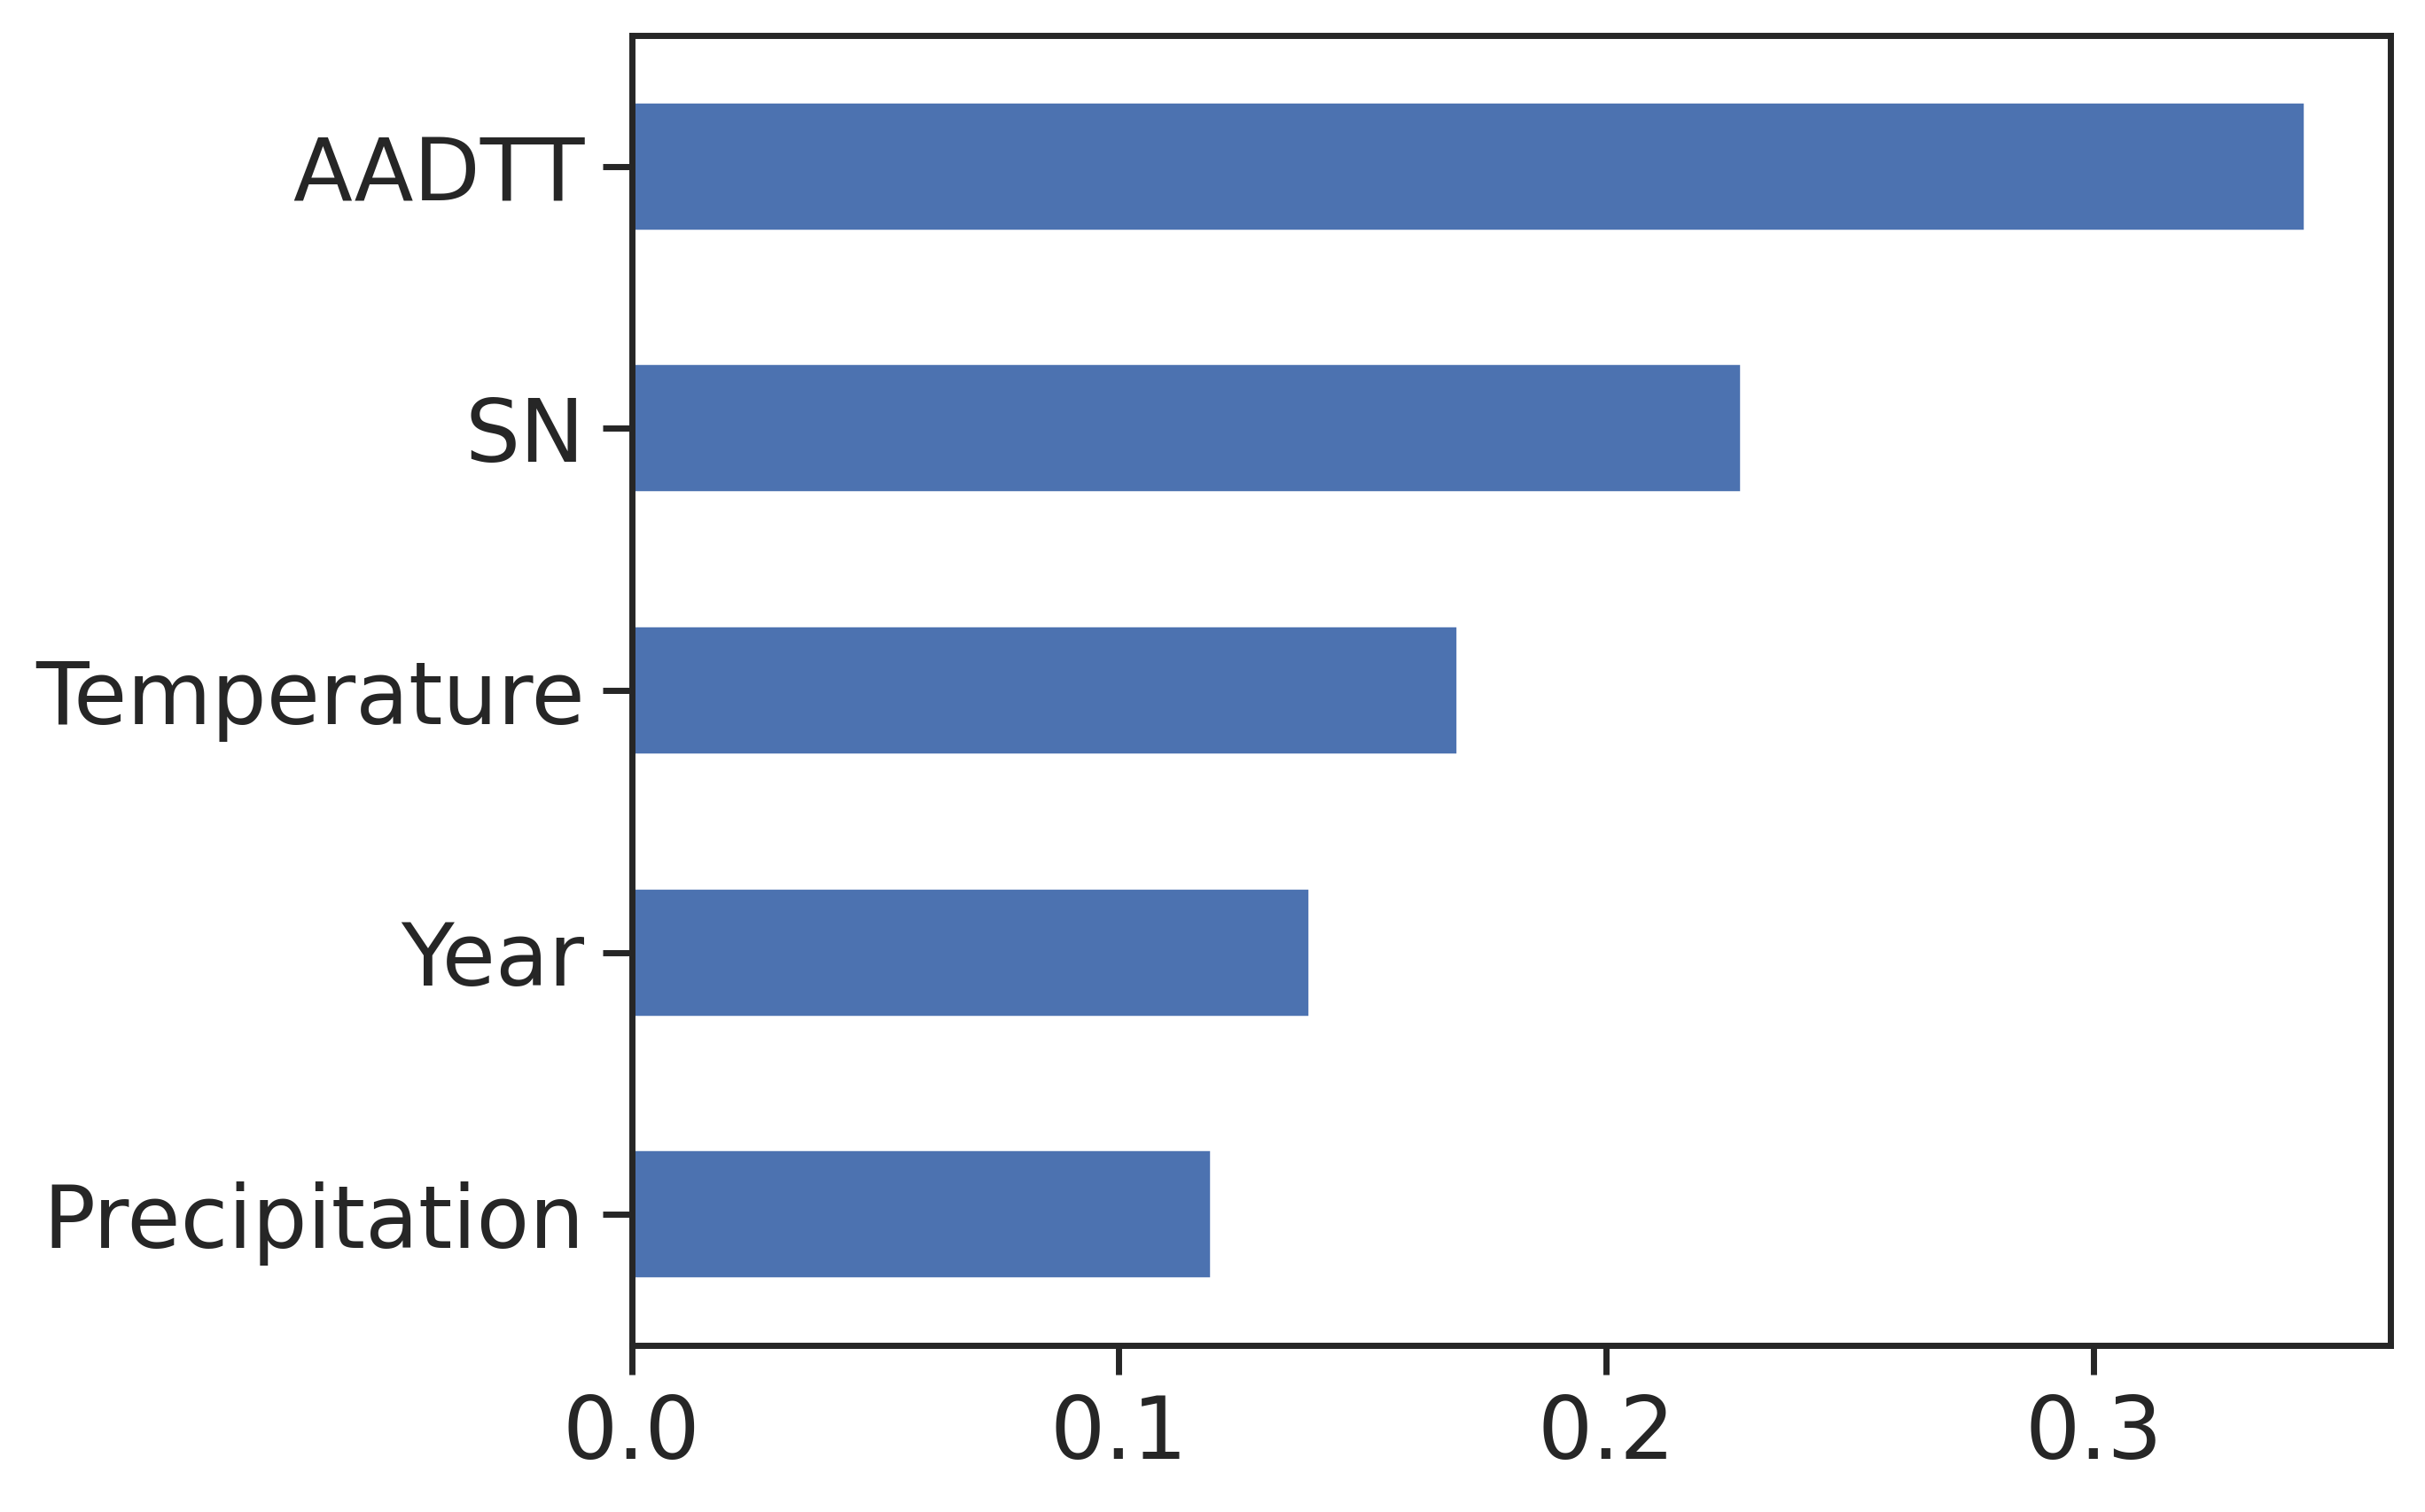

In [20]:
# feature importance for DT
importanceDT = DT_reg.feature_importances_
graphImportanceDT = pd.Series(importanceDT, index=X_train.columns).sort_values().plot.barh()
fig = graphImportanceDT.get_figure()
fig.savefig('results/importanceDT.png')

In [21]:
# summarize feature importance for DT

for i, v in enumerate(importanceDT):
    print('Feature: %s, Score: %.5f' % (X_train.columns[i], v))

Feature: Year, Score: 0.13944
Feature: Precipitation, Score: 0.11918
Feature: Temperature, Score: 0.16980
Feature: AADTT, Score: 0.34363
Feature: SN, Score: 0.22795


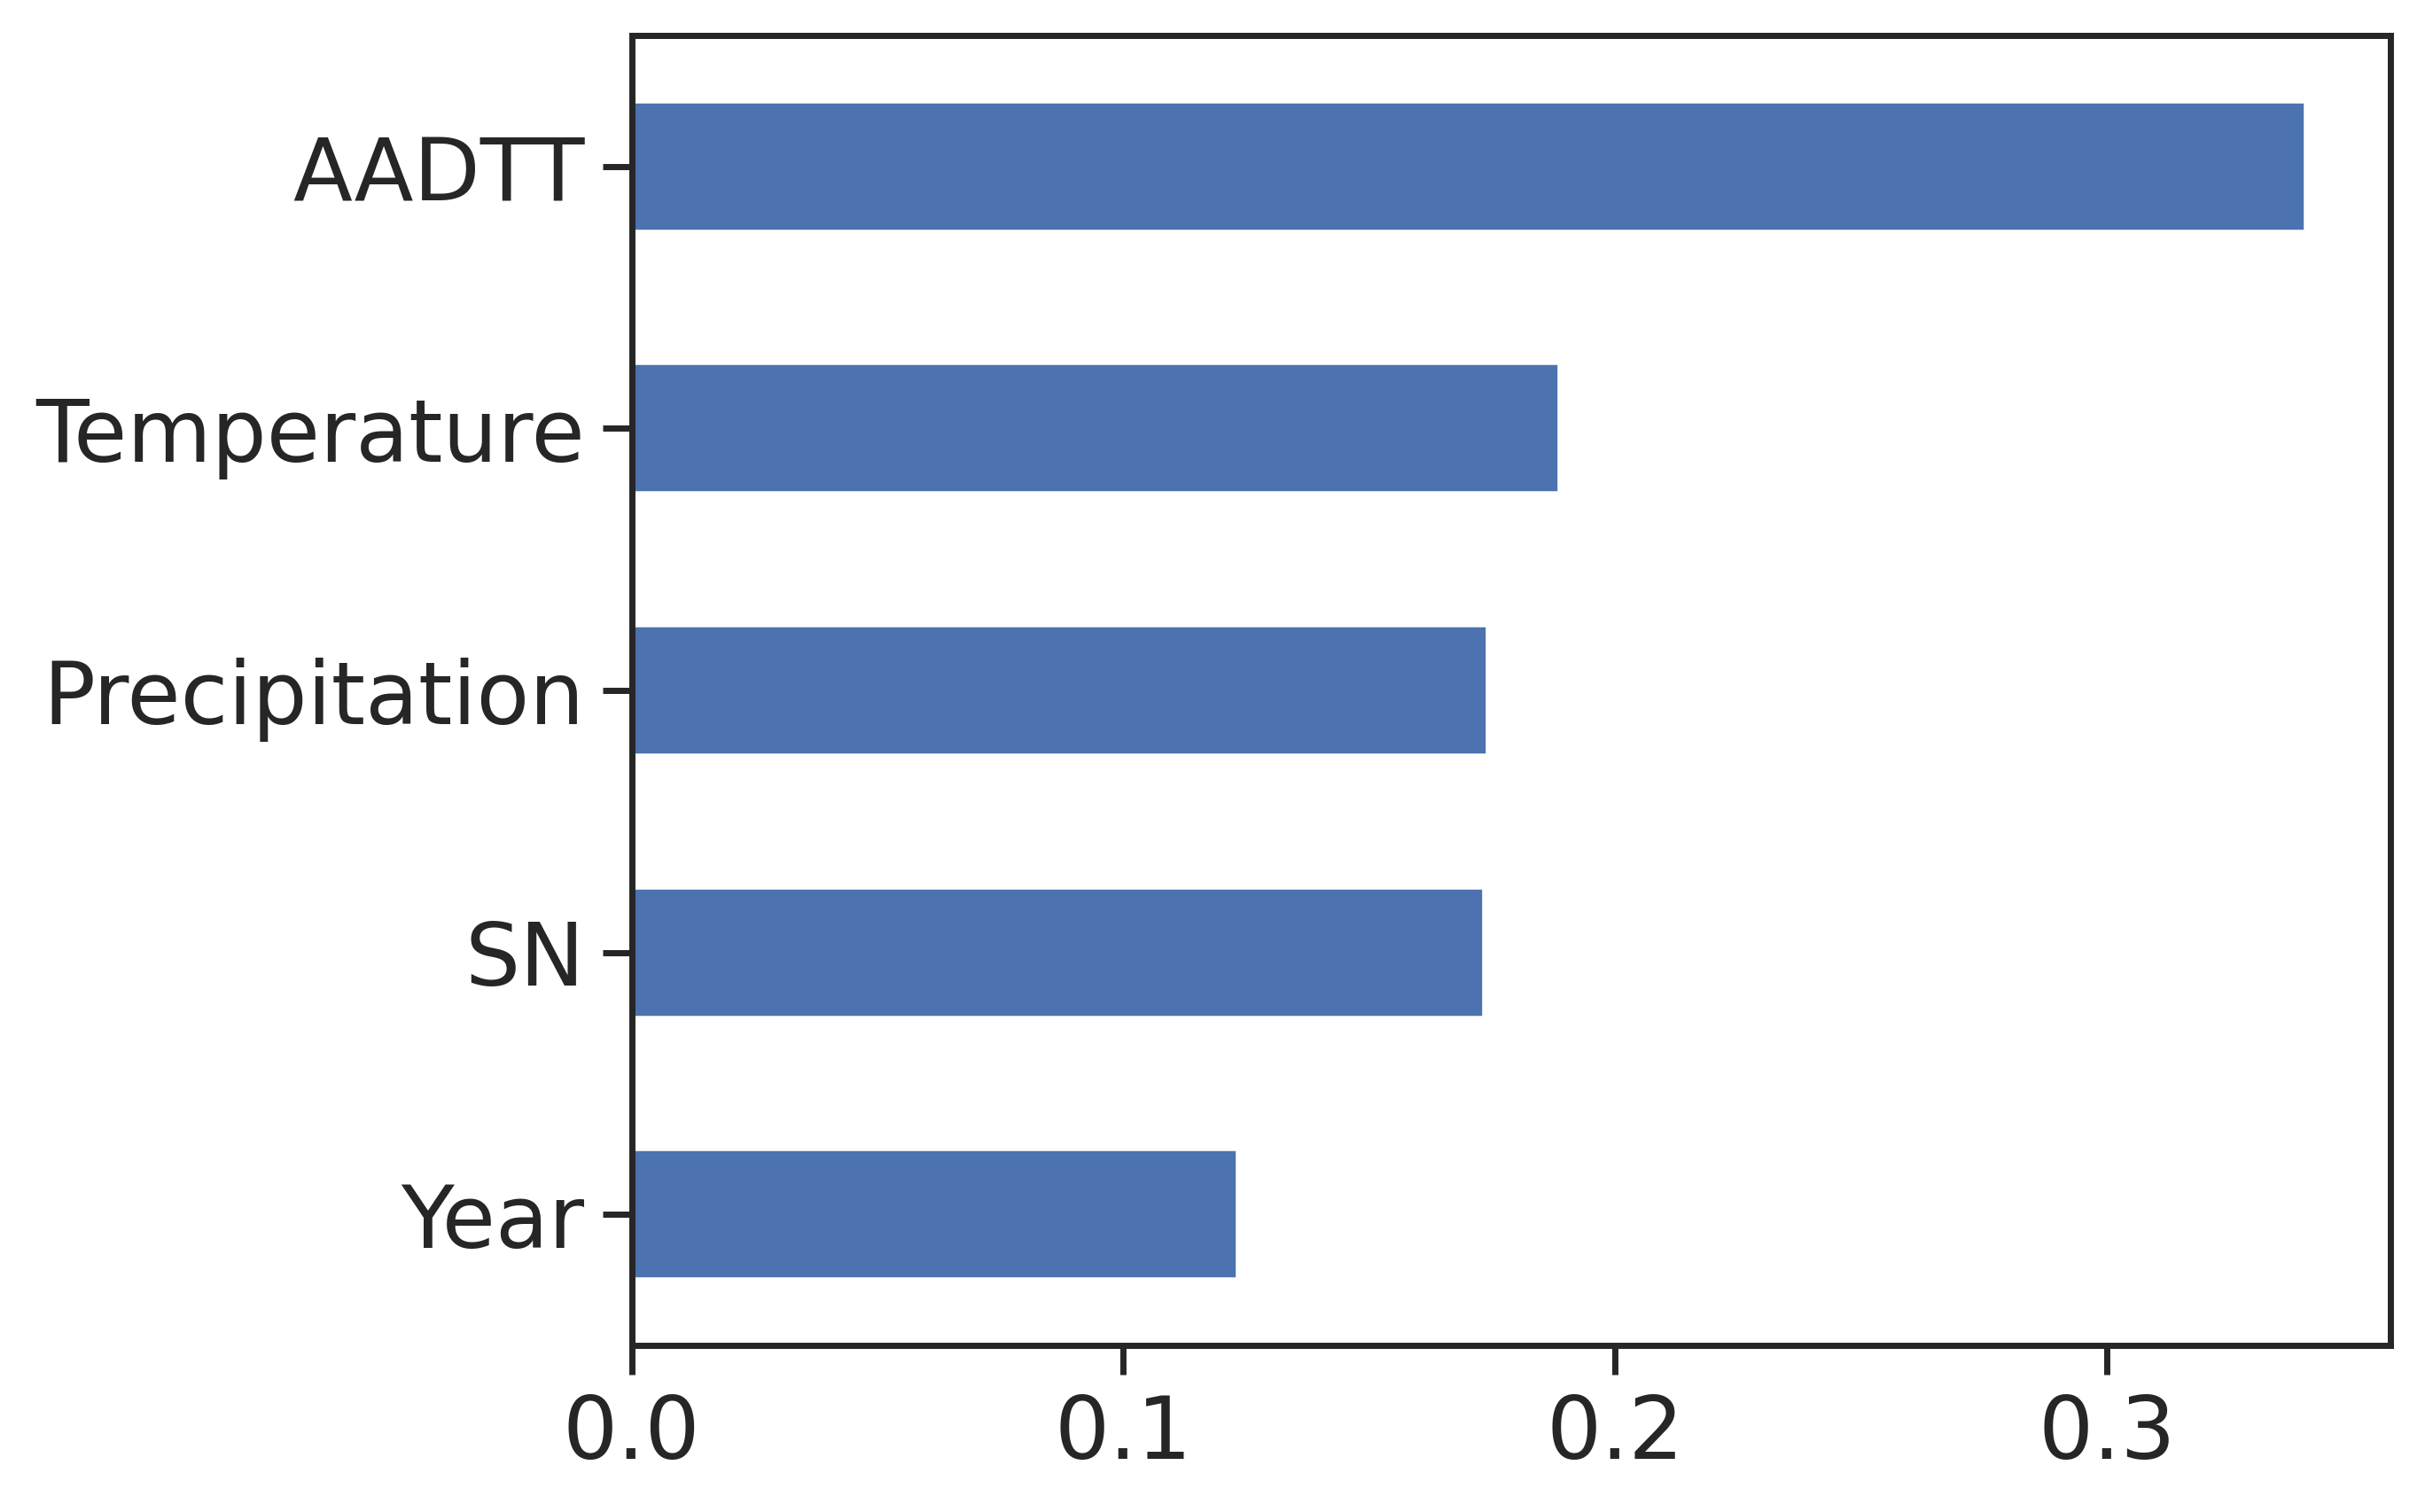

In [22]:
# feature importance for RF
importanceRF = RF_reg.feature_importances_
graphImportanceRF = pd.Series(importanceRF, index=X_train.columns).sort_values().plot.barh()

fig = graphImportanceRF.get_figure()
fig.savefig('results/importanceRF.png')

In [23]:
# summarize feature importance for RF
for i, v in enumerate(importanceRF):
    print('Feature: %s, Score: %.5f' % (X_train.columns[i], v))

Feature: Year, Score: 0.12328
Feature: Precipitation, Score: 0.17412
Feature: Temperature, Score: 0.18867
Feature: AADTT, Score: 0.34049
Feature: SN, Score: 0.17344


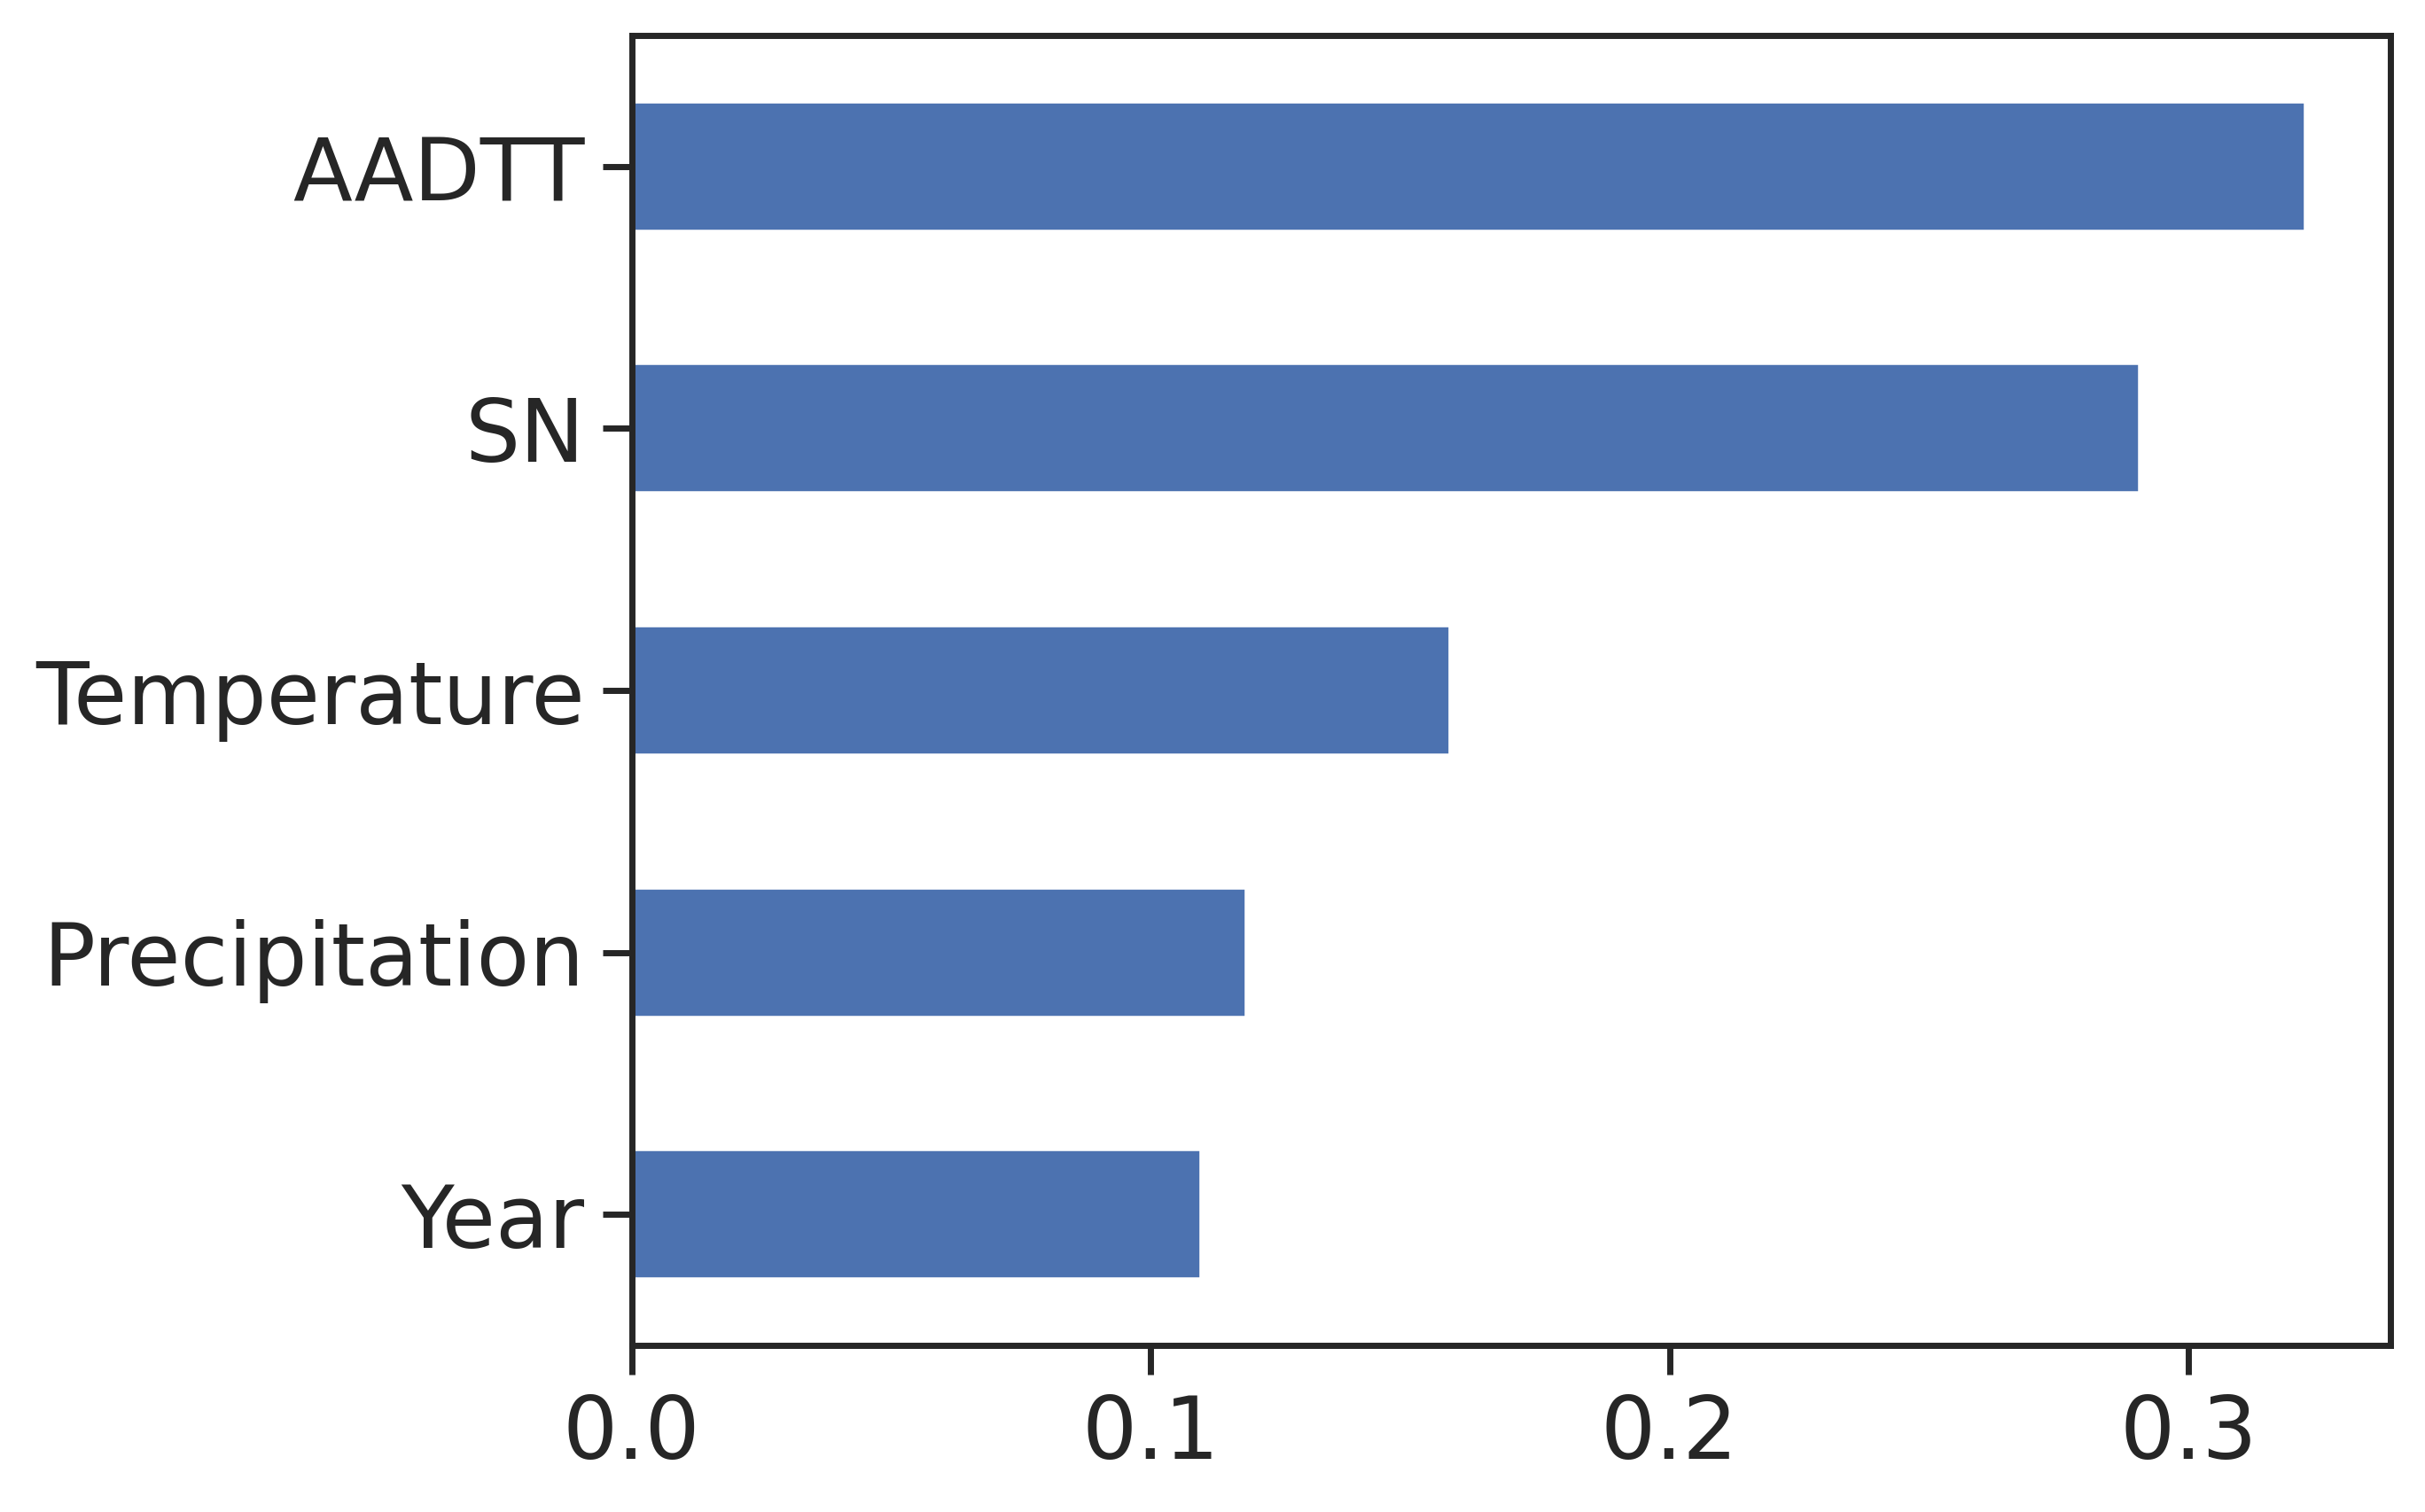

In [24]:
# feature importance for XGBoost
importanceXG = XG_reg.feature_importances_
graphImportanceXG = pd.Series(importanceXG, index=X_train.columns).sort_values().plot.barh()

fig = graphImportanceXG.get_figure()
fig.savefig('results/importanceXG.png')

In [25]:
# summarize feature importance for XGBoost
for i, v in enumerate(importanceXG):
    print('Feature: %s, Score: %.5f' % (X_train.columns[i], v))

Feature: Year, Score: 0.10990
Feature: Precipitation, Score: 0.11866
Feature: Temperature, Score: 0.15789
Feature: AADTT, Score: 0.32271
Feature: SN, Score: 0.29083


In [26]:
# Metrics
def r2(y_test, y_pred):
    return round(r2_score(y_test, y_pred), 2)


def rmse(y_test, y_pred):
    return round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)


def mae(y_test, y_pred):
    return round(mean_absolute_error(y_test, y_pred), 2)


# r2
r2DT = r2(y_test, resultDT)
r2RF = r2(y_test, resultRF)
r2XG = r2(y_test, resultXG)

# rmse
rmseDT = rmse(y_test, resultDT)
rmseRF = rmse(y_test, resultRF)
rmseXG = rmse(y_test, resultXG)

# MAE
maeDT = mae(y_test, resultDT)
maeRF = mae(y_test, resultRF)
maeXG = mae(y_test, resultXG)

In [27]:
# calc. of samples
n_train = int(X.shape[0]*train_threshold)
n_test = int(X.shape[0])-n_train

In [28]:
# np.shape(TreeRegResult)[0]
x = np.arange(np.shape(y_test)[0])

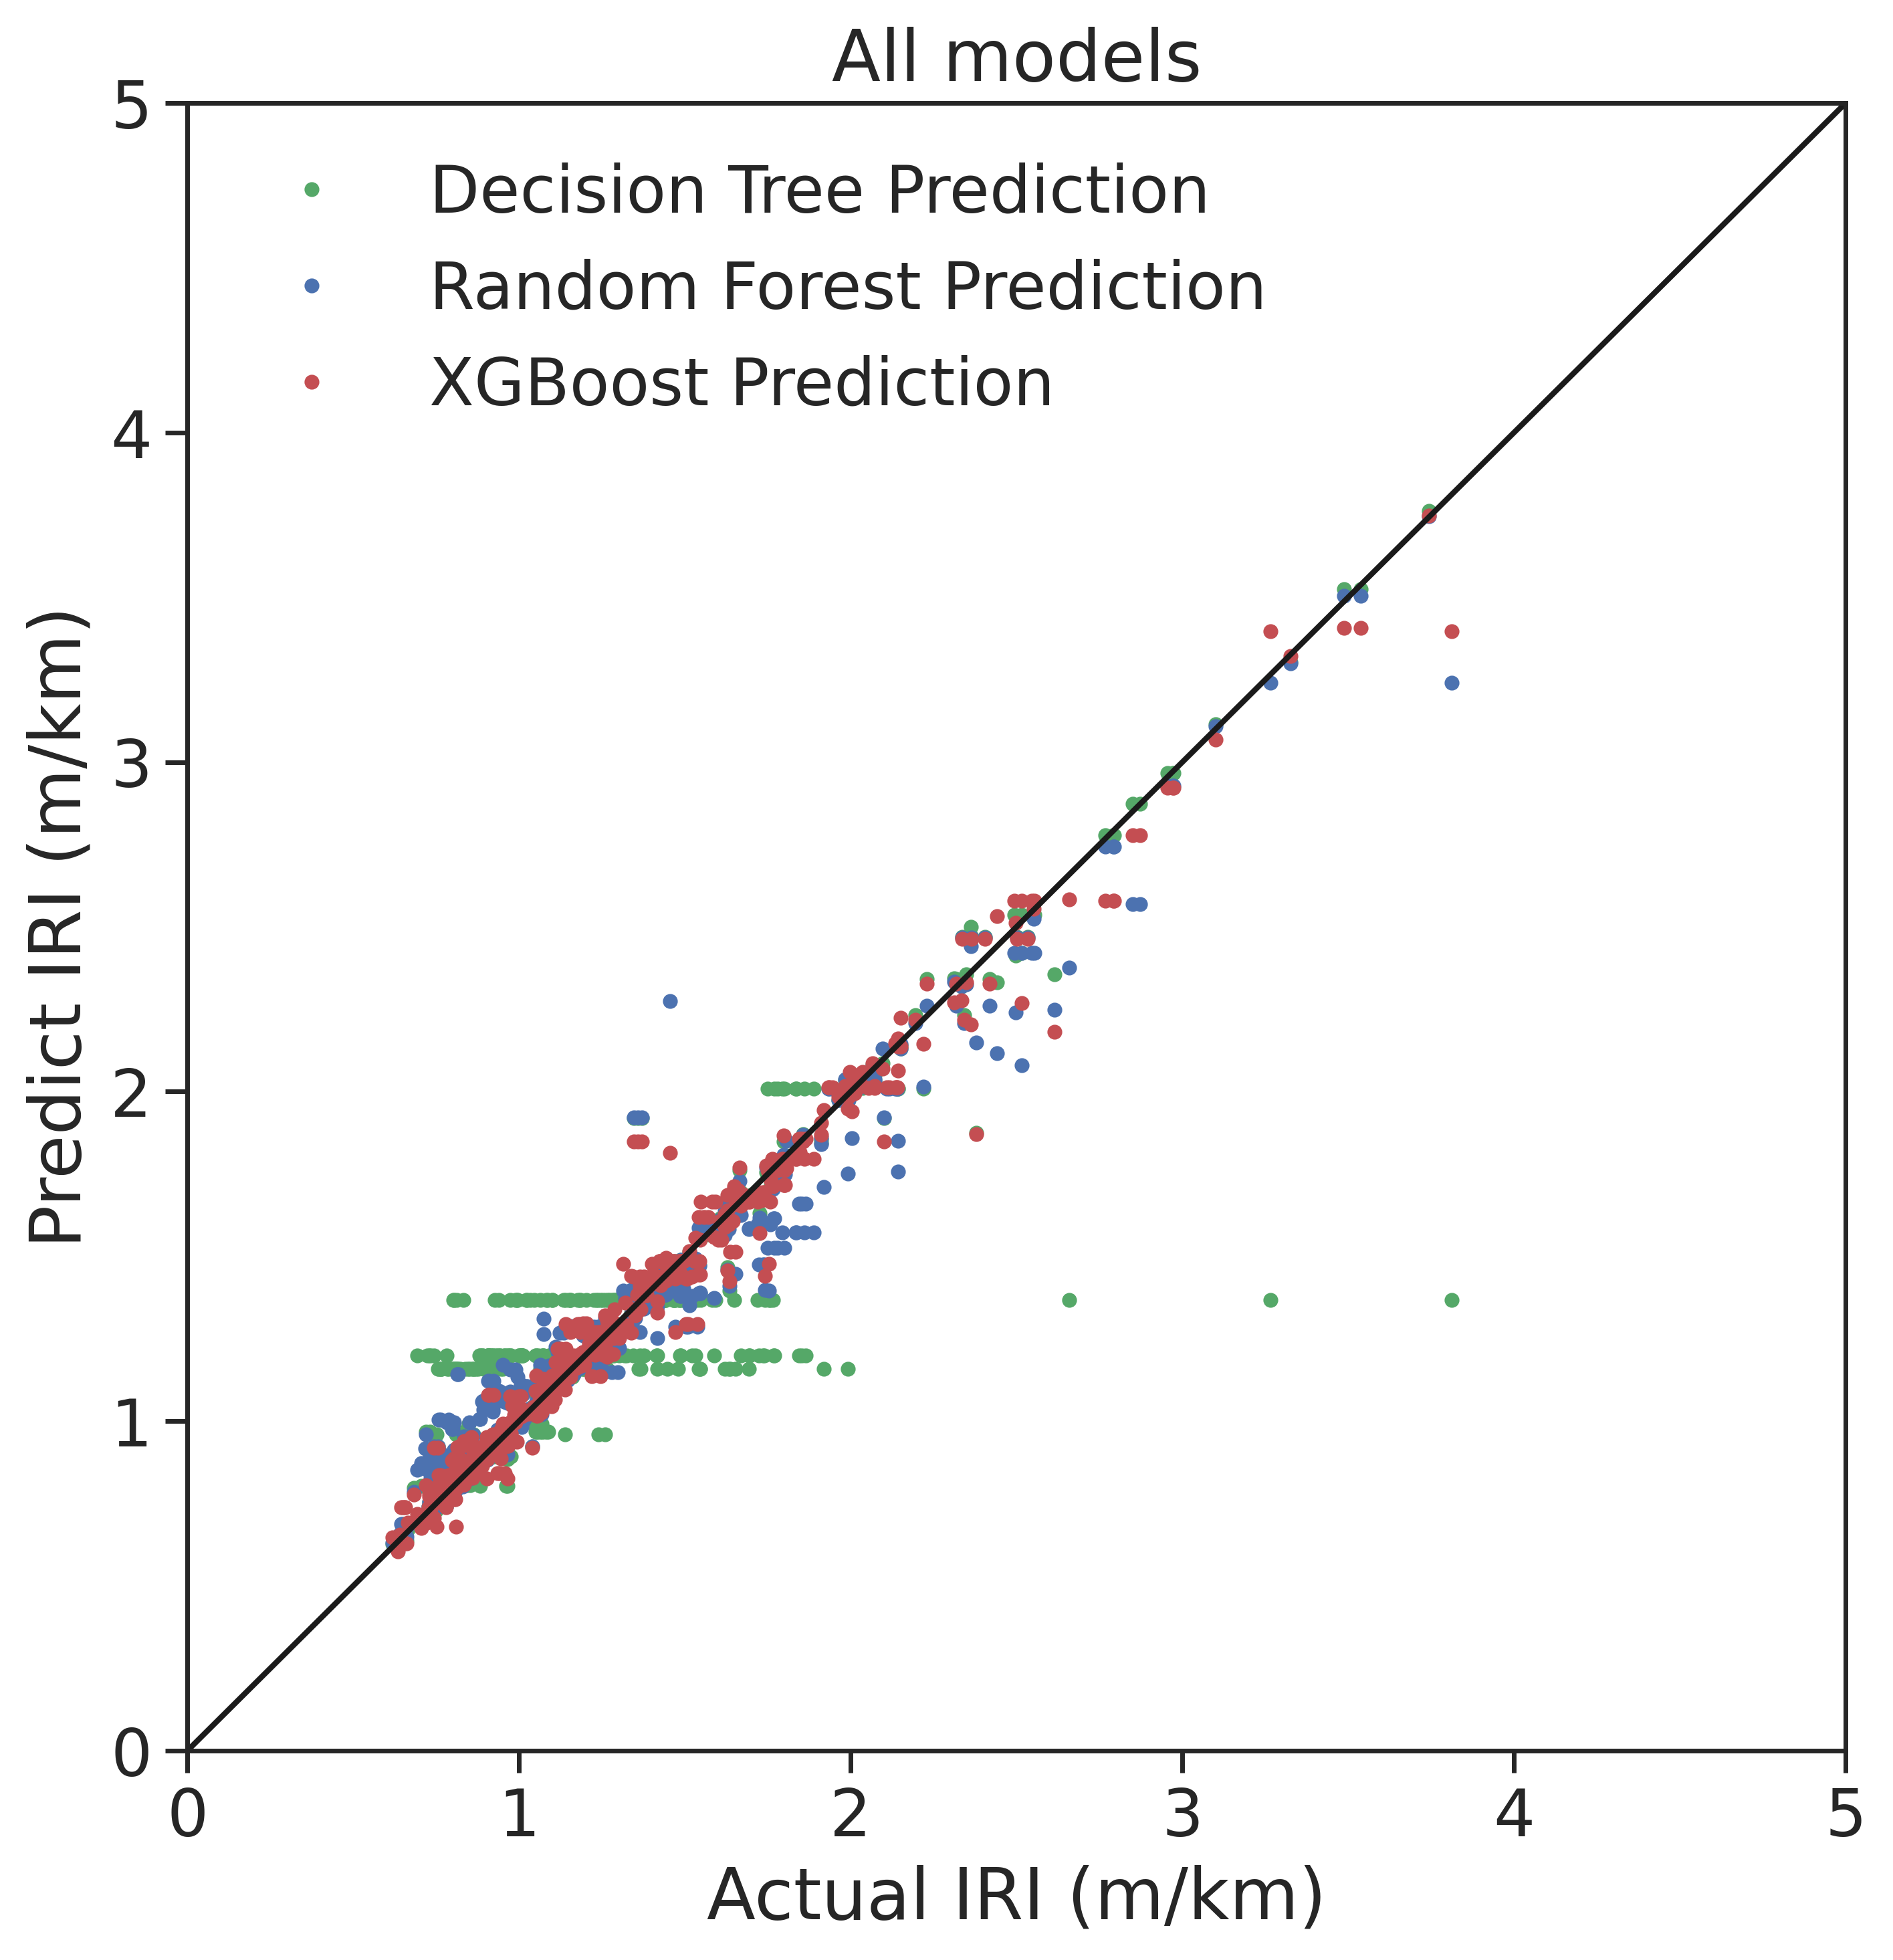

In [29]:
# plot all results
plt.rcParams['figure.figsize'] = (8, 8)
plt.plot(y_test, resultDT, 'g.', label='Decision Tree Prediction')
plt.plot(y_test, resultRF, 'b.', label='Random Forest Prediction')
plt.plot(y_test, resultXG, 'r.', label='XGBoost Prediction')
plt.xlabel('Actual IRI (m/km)')
plt.ylabel('Predict IRI (m/km)')
plt.plot(x, x, 'k-')  # identity line
# poor to fair threshold.. 2.7
# plt.hlines(2.7, 0, 2.7, colors='black', linestyles='dashed', linewidth=1.2)
# plt.vlines(2.7, 0, 2.7, colors='black', linestyles='dashed', linewidth=1.2)
plt.axis([0, 5, 0, 5])
leg = plt.legend()
leg.get_frame().set_linewidth(0.0)
plt.title("All models")
plt.savefig('results/treesComparison.png')
plt.show()

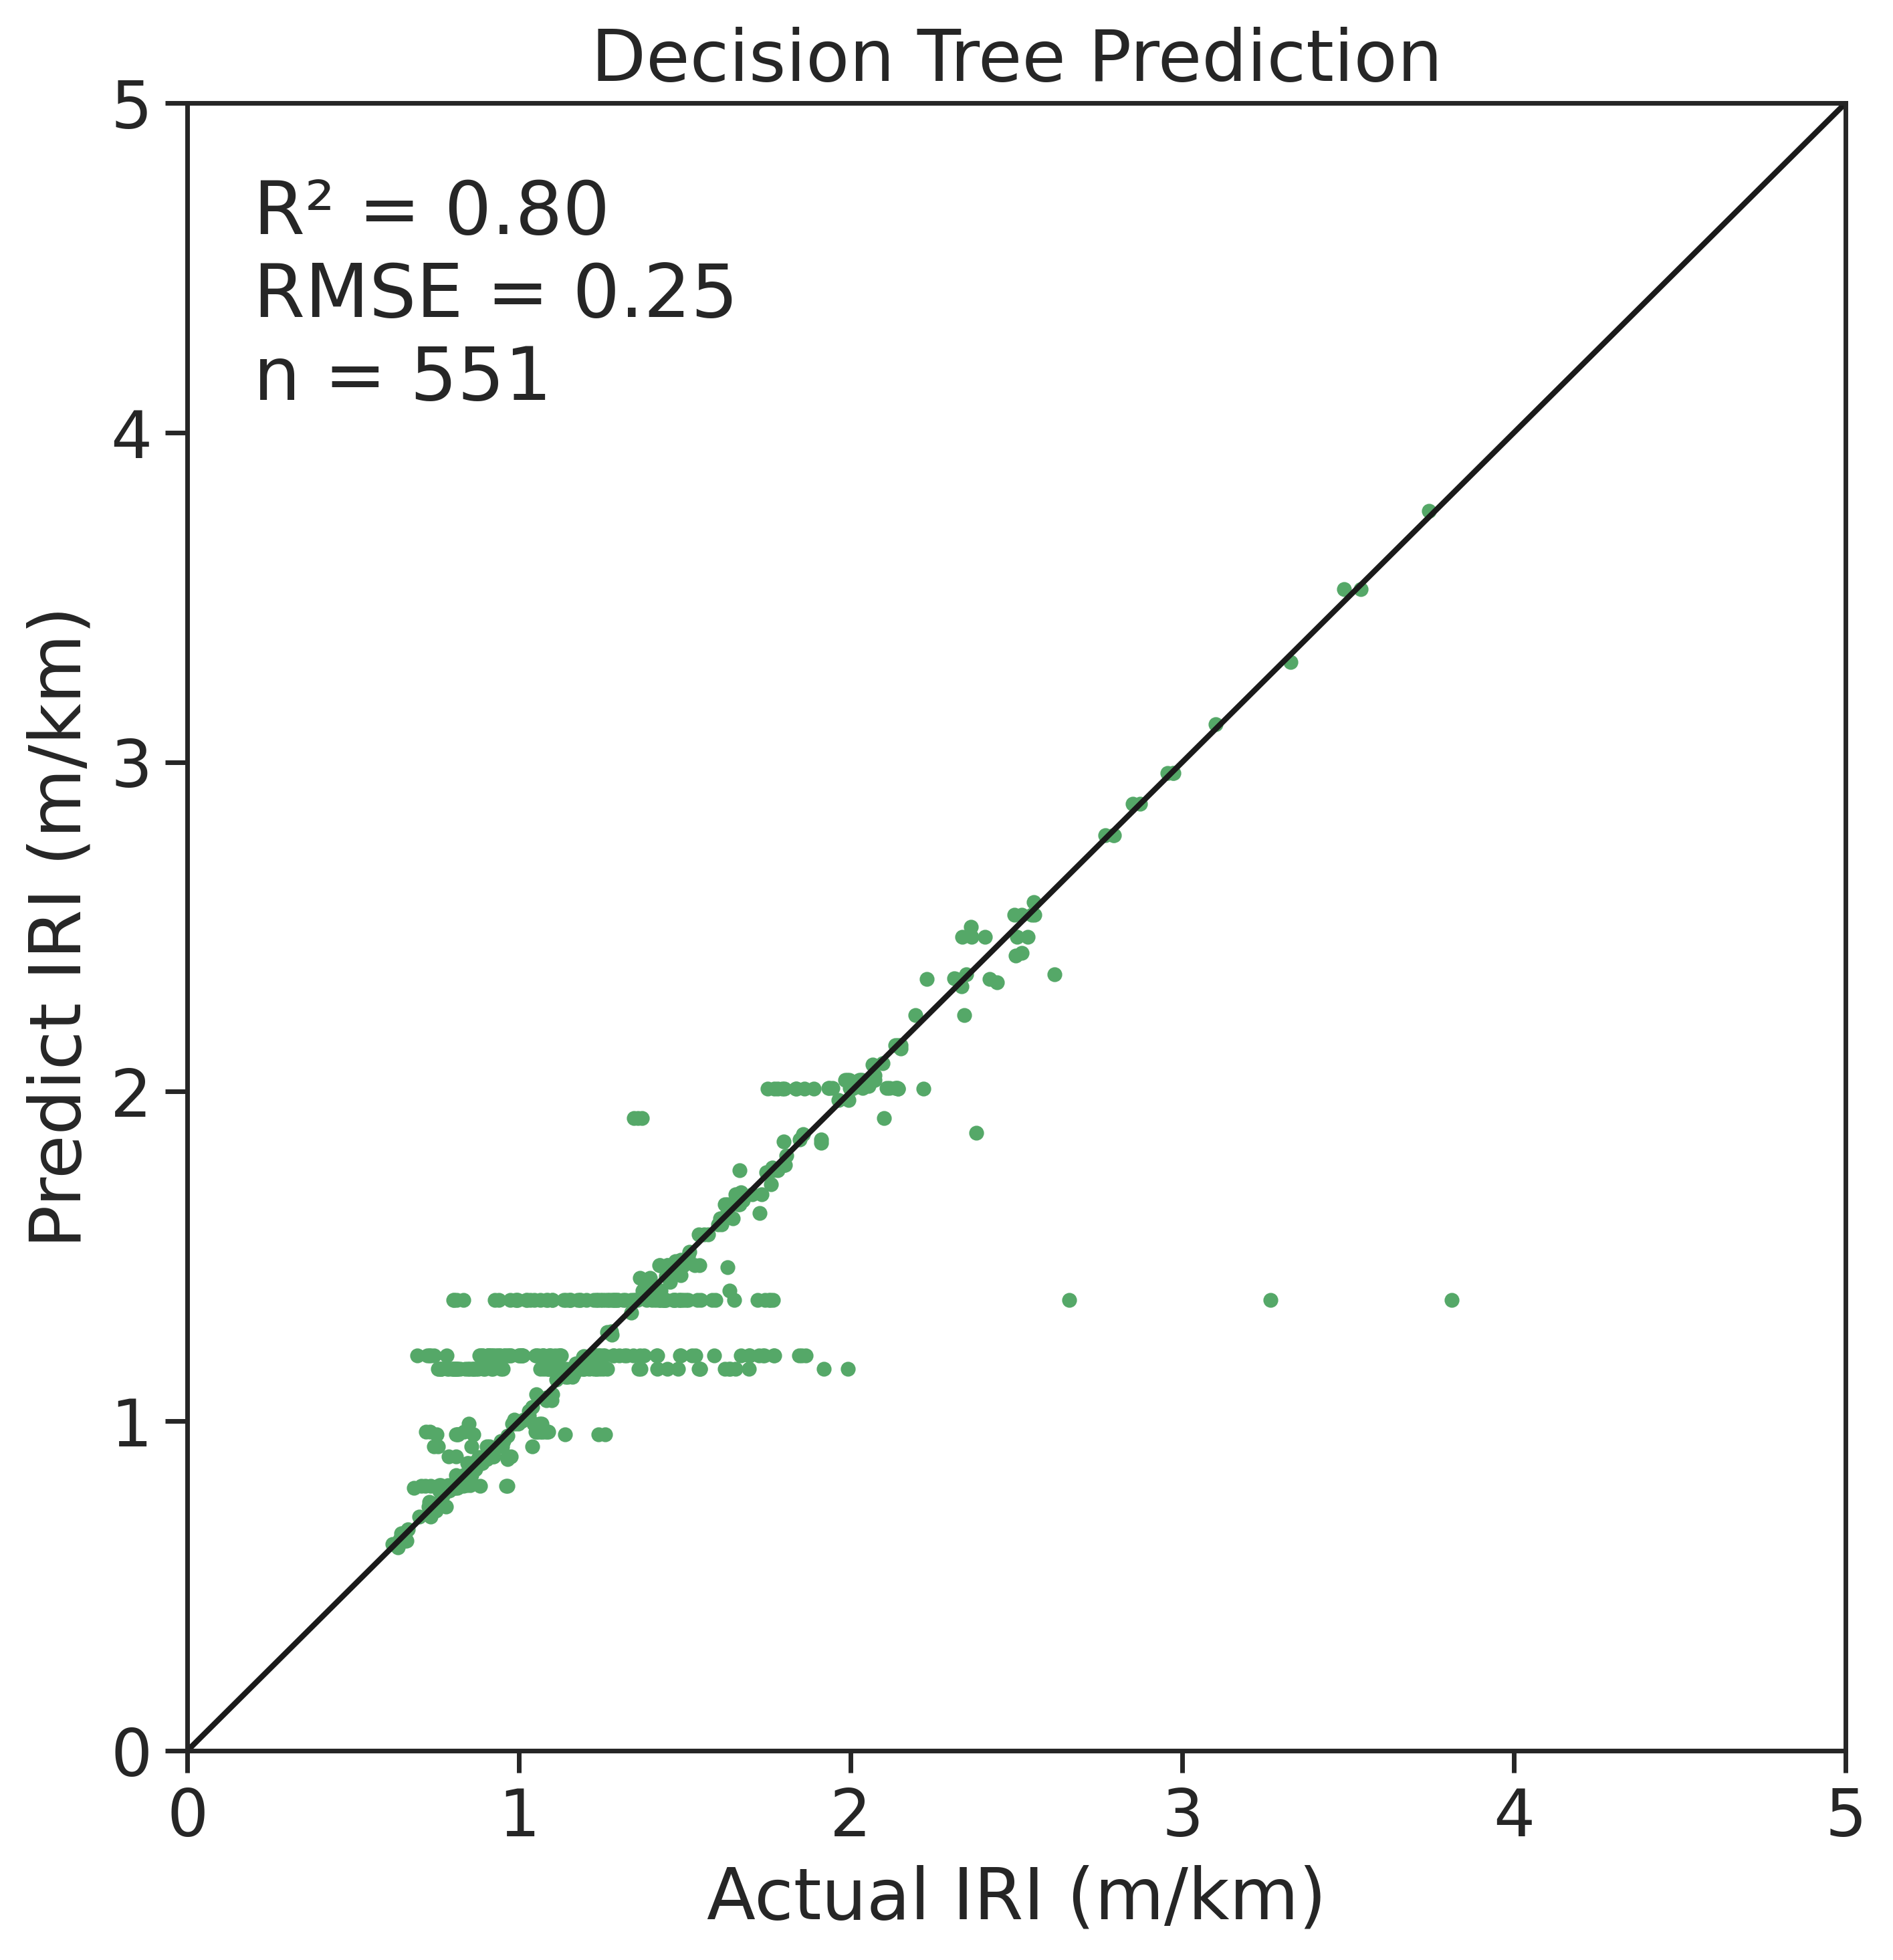

In [30]:
# plot DT results (test)
plt.rcParams['figure.figsize'] = (8,8)
plt.plot(y_test, resultDT, 'g.')
plt.xlabel('Actual IRI (m/km)')
plt.ylabel('Predict IRI (m/km)')
plt.plot(x, x, 'k-')  # identity line
plt.axis([0, 5, 0, 5])
s = "R² = %.2f \nRMSE = %.2f\nn = %i" % (r2DT, rmseDT, n_test)
plt.text(0.2, 4.1, s, fontsize=20)
plt.title("Decision Tree Prediction")
plt.savefig('results/DT.png')
plt.show()

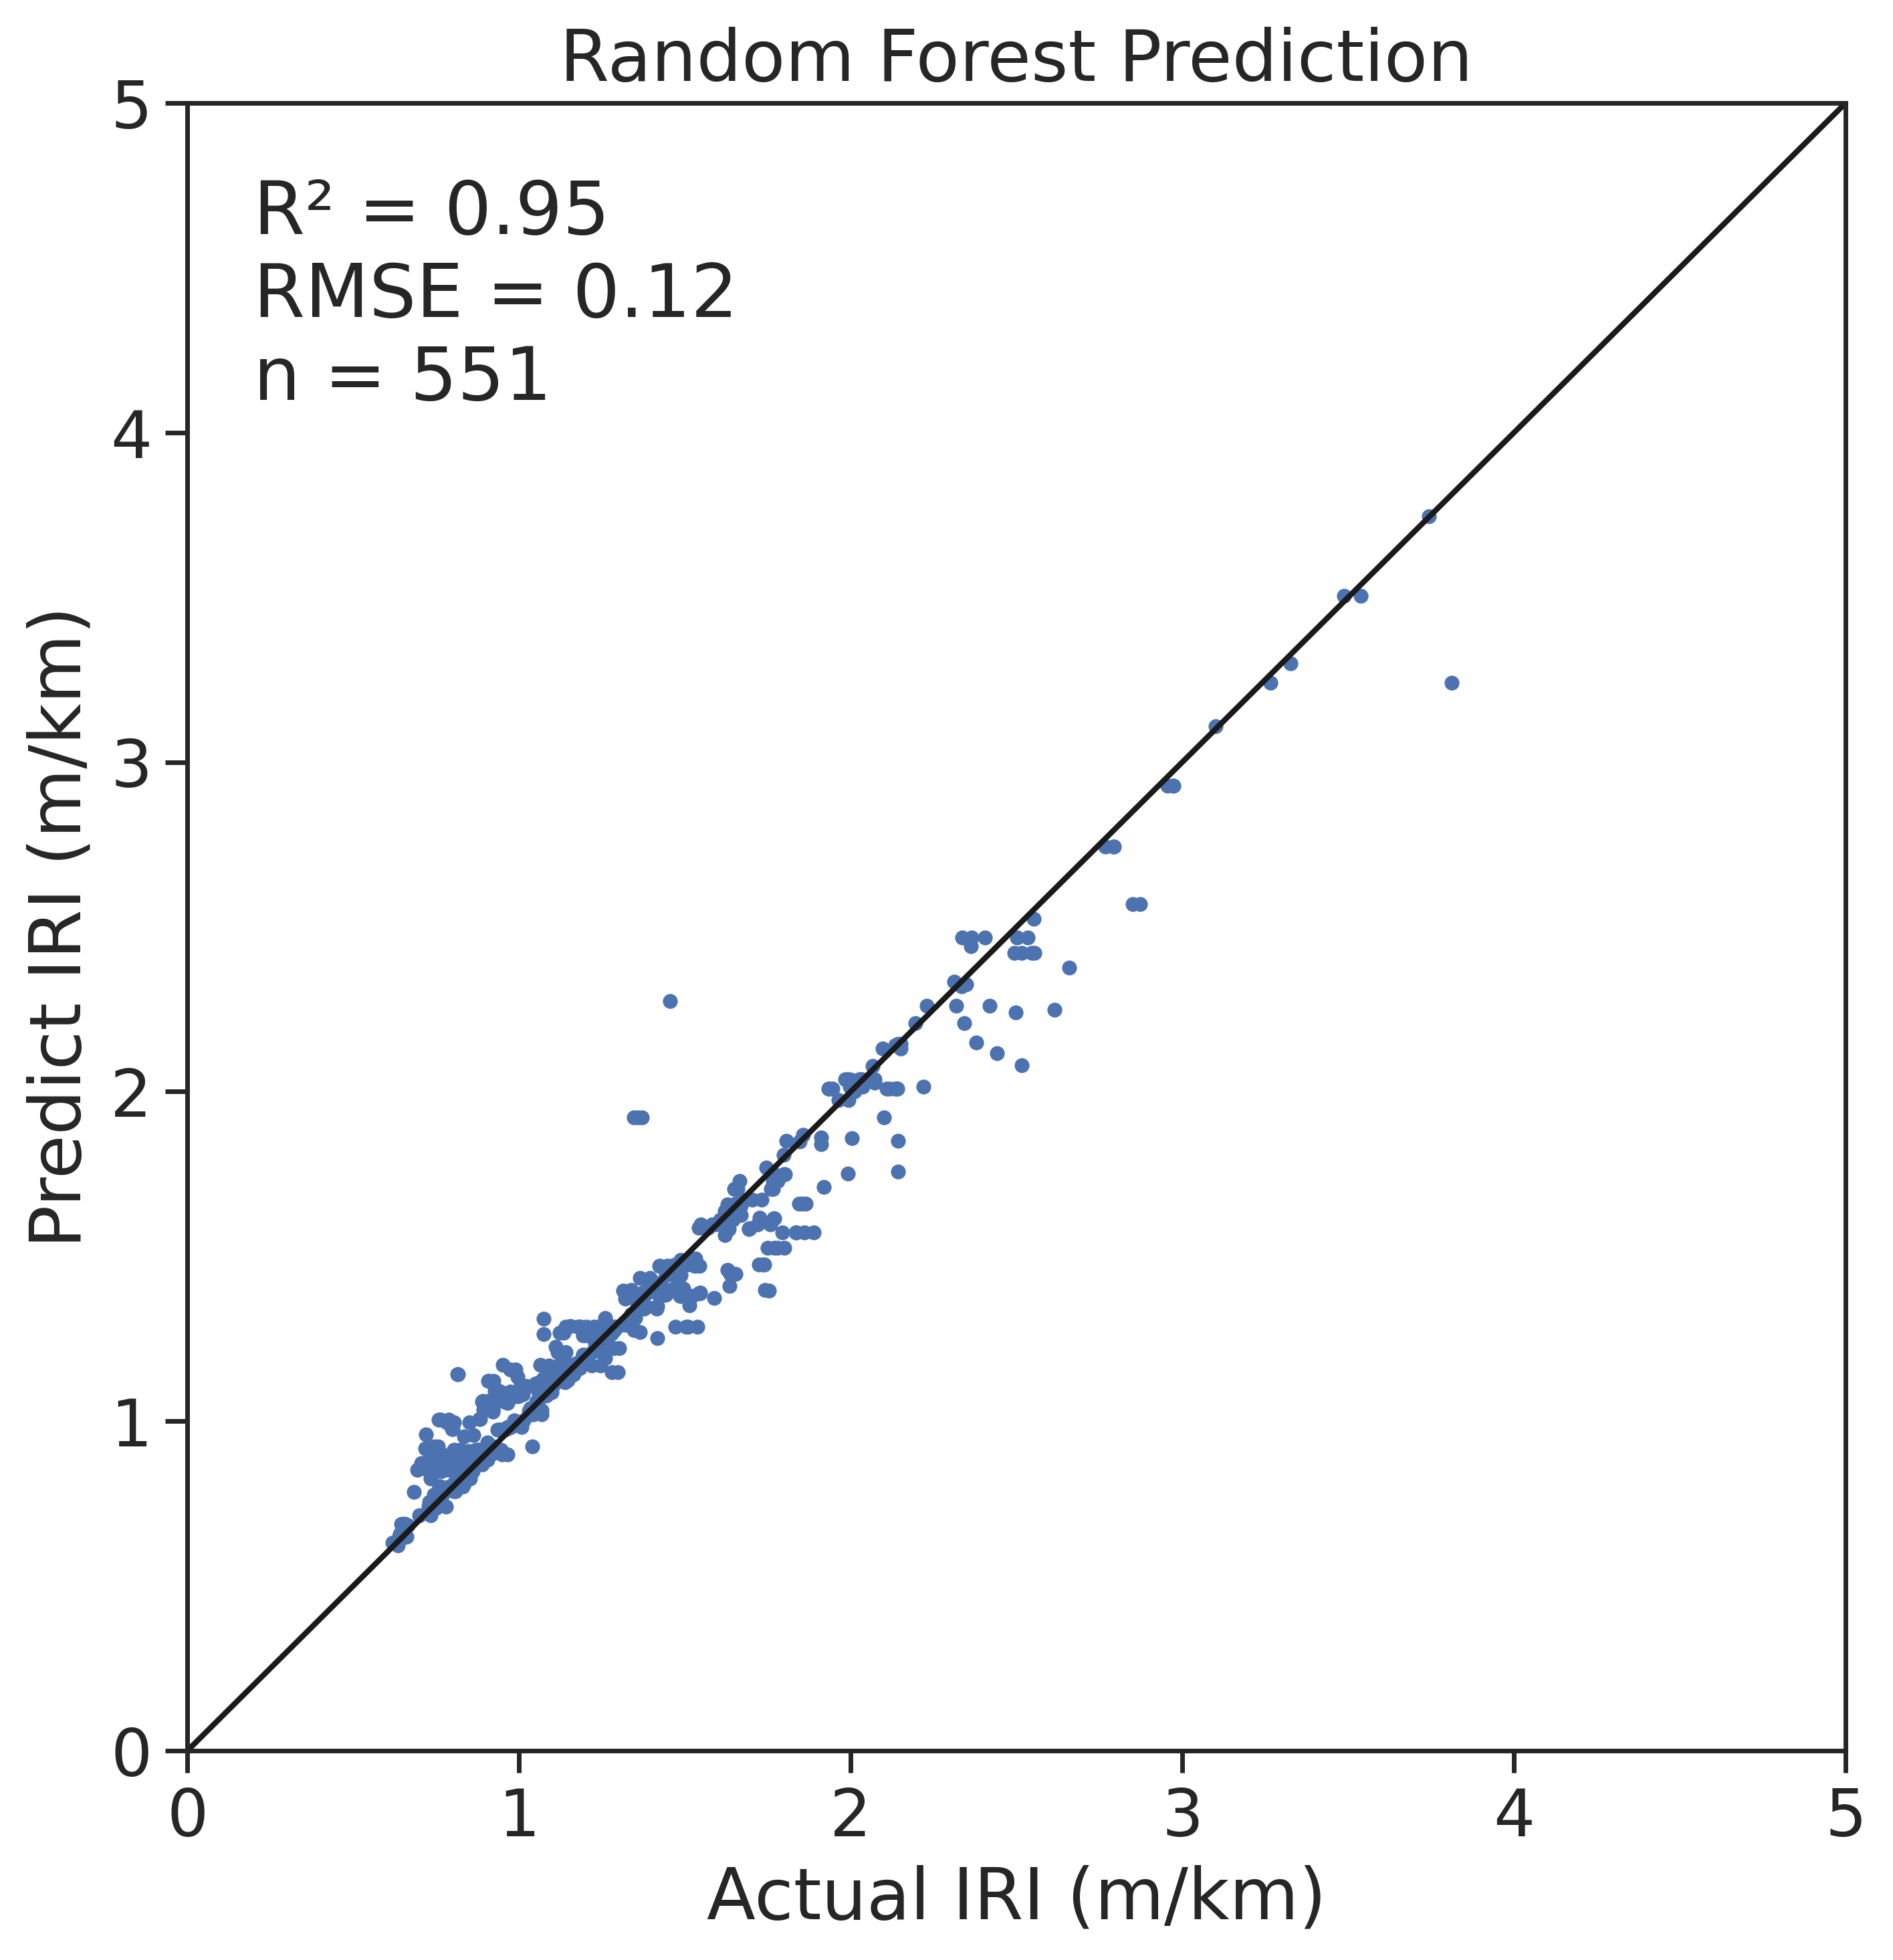

In [31]:
# plot RF results
plt.rcParams['figure.figsize'] = (8, 8)
plt.plot(y_test, resultRF, 'b.')
plt.xlabel('Actual IRI (m/km)')
plt.ylabel('Predict IRI (m/km)')
plt.plot(x, x, 'k-')  # identity line
plt.axis([0, 5, 0, 5])
s = "R² = %.2f \nRMSE = %.2f\nn = %i" % (r2RF, rmseRF, n_test)
plt.text(0.2, 4.1, s, fontsize=20)
plt.title("Random Forest Prediction")
plt.savefig('results/RF.png')
plt.show()

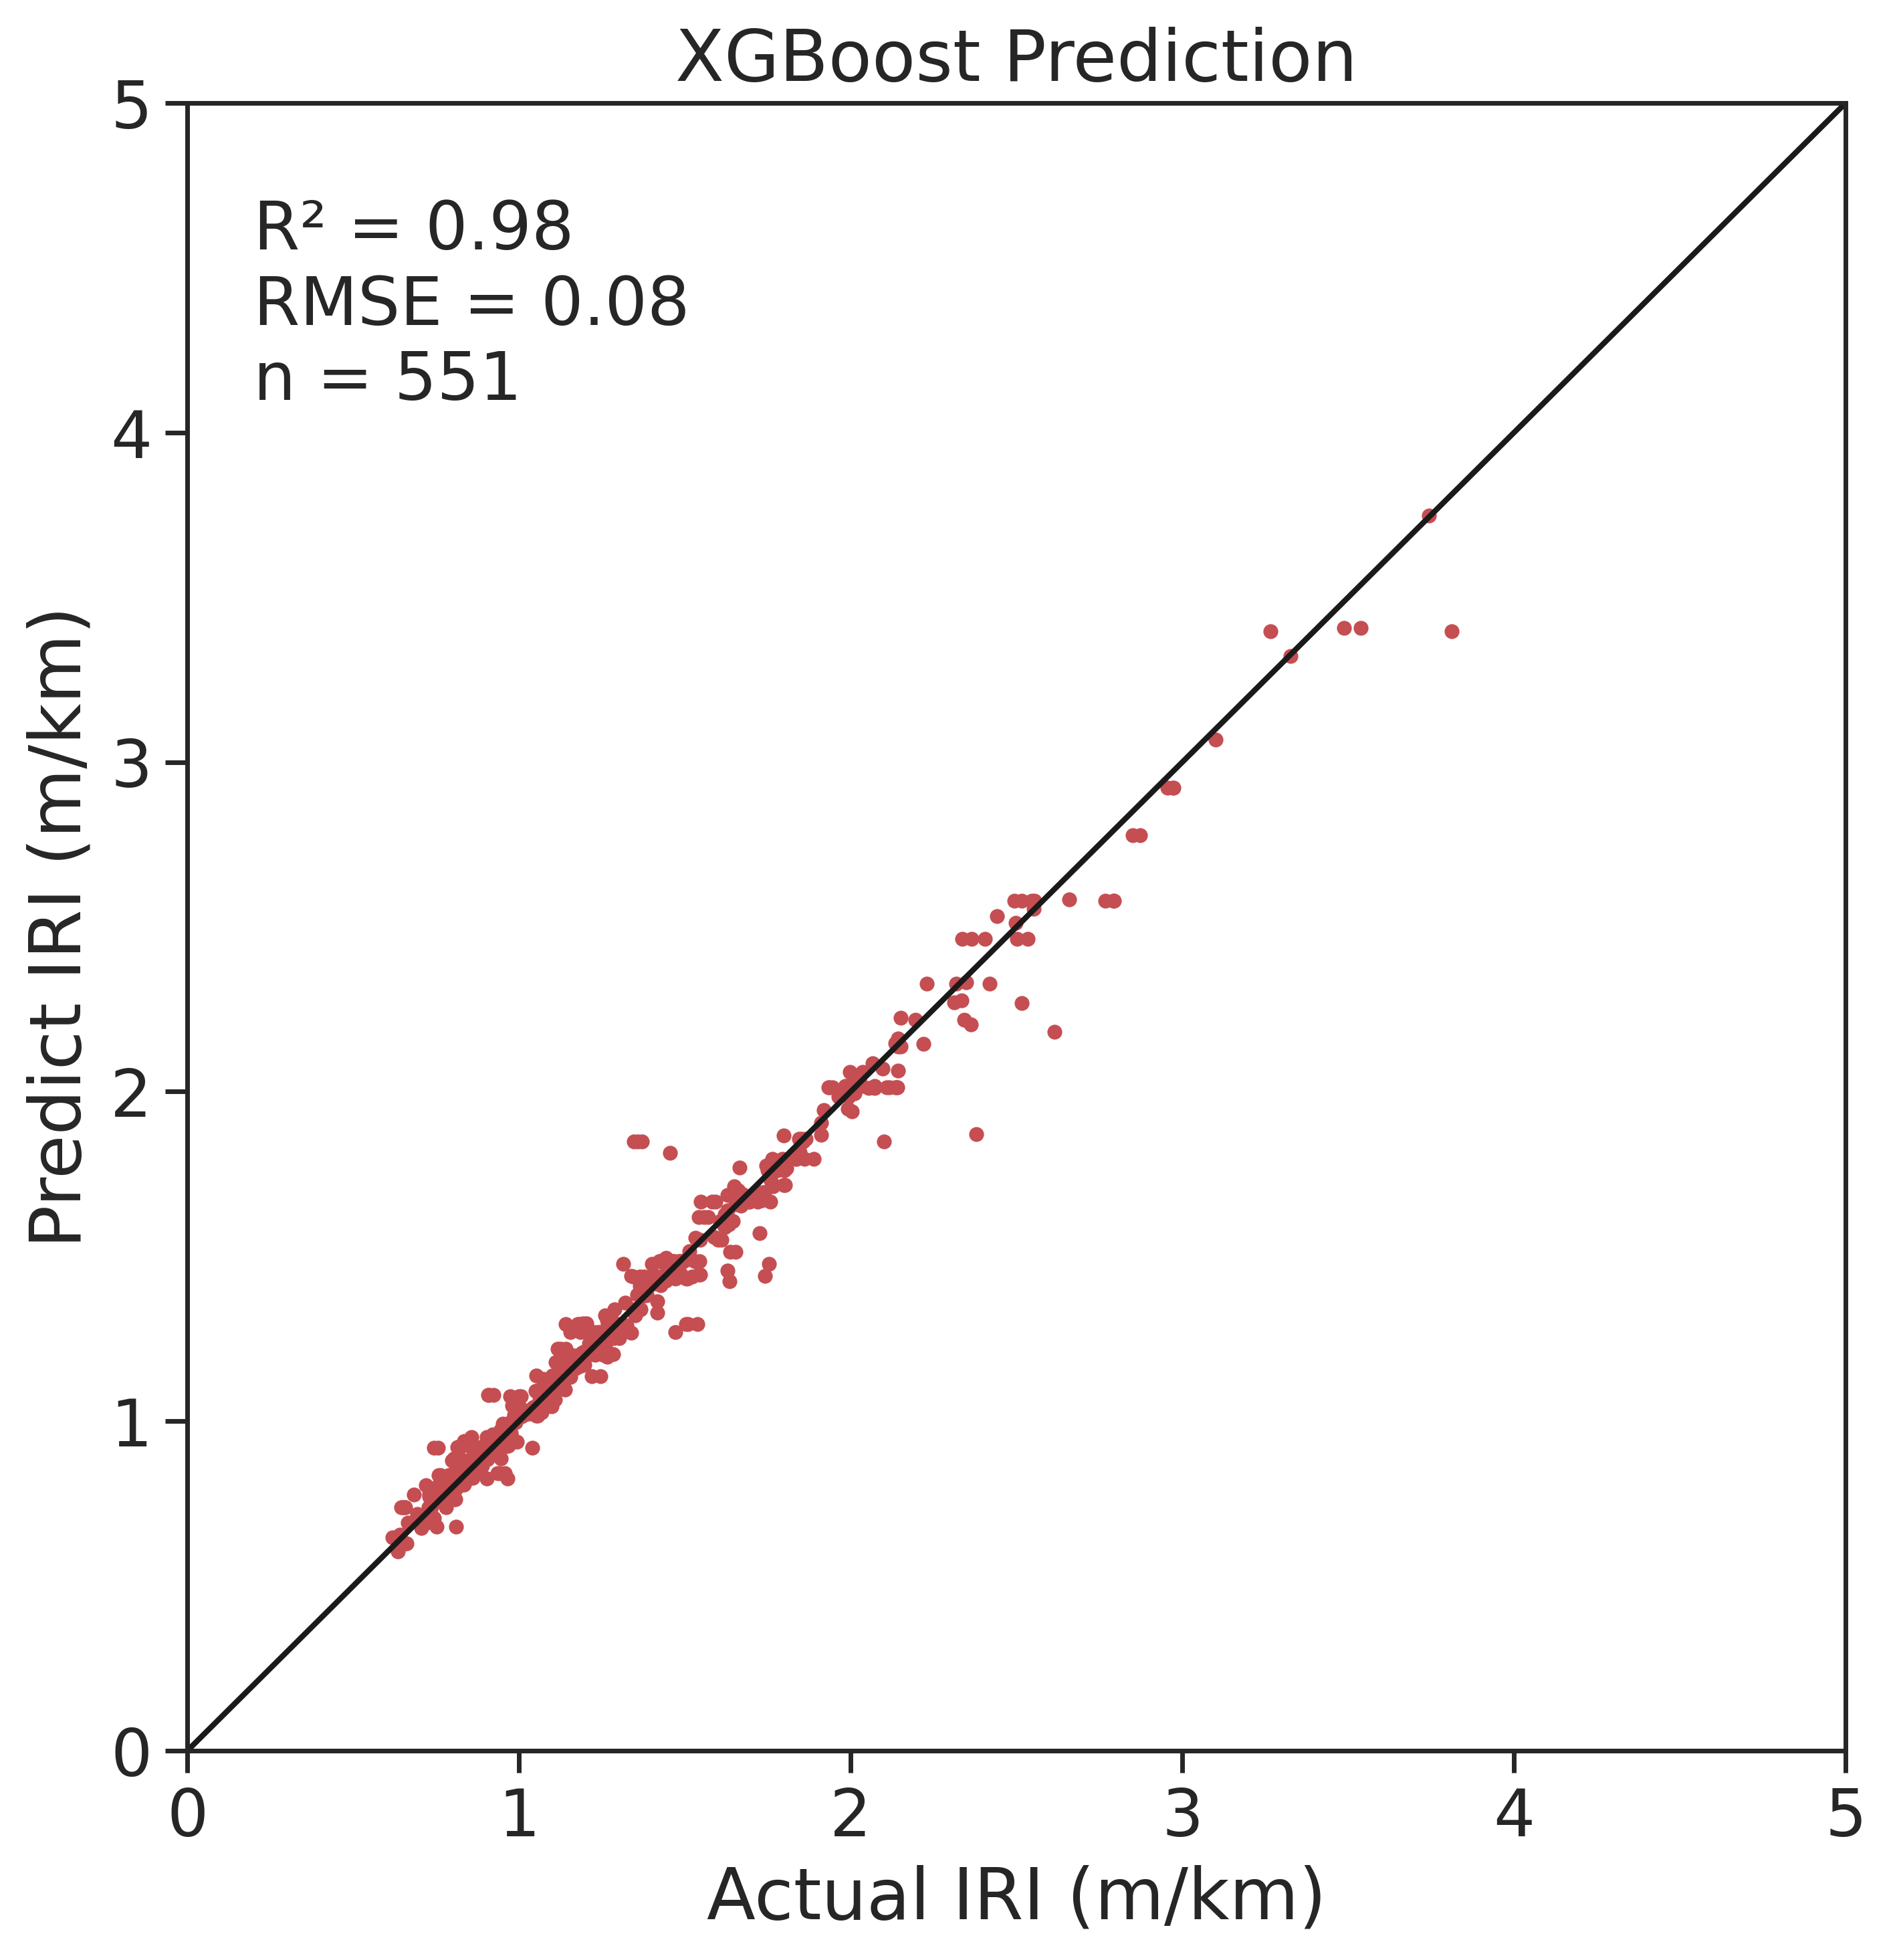

In [32]:
# plot XGBoost results
plt.rcParams['figure.figsize'] = (8, 8)
plt.plot(y_test, resultXG, 'r.', label='XGBoost Prediction')
plt.xlabel('Actual IRI (m/km)')
plt.ylabel('Predict IRI (m/km)')
plt.plot(x, x, 'k-')  # identity line
plt.axis([0, 5, 0, 5])
s = "R² = %.2f \nRMSE = %.2f\nn = %i" % (r2XG, rmseXG, n_test)
plt.text(0.2, 4.1, s, fontsize=18)
plt.title("XGBoost Prediction")
plt.savefig('results/XGBoost.png')
plt.show()

In [33]:
# save models
filenameDT = 'results/ltppIRI_DT.mlmodel'
pickle.dump(DT_reg, open(filenameDT, 'wb'))

filenameRF = 'results/ltppIRI_RF.mlmodel'
pickle.dump(DT_reg, open(filenameRF, 'wb'))

filenameXG = 'results/ltppIRI_XG.mlmodel'
pickle.dump(DT_reg, open(filenameXG, 'wb'))

In [34]:
# tuning depth of trees R2
depth = 10

max_depths = np.linspace(1, depth, depth, endpoint=True)

r2DT_results = []
r2RF_results = []
r2XG_results = []

rmseDT_results = []
rmseRF_results = []
rmseXG_results = []

maeDT_results = []
maeRF_results = []
maeXG_results = []

for max_depth in max_depths:
    dt = DecisionTreeRegressor(random_state=0, max_depth=int(max_depth))
    dt.fit(X_train, y_train)   
    DT_pred = dt.predict(X_test)   
    
    r2_DT = r2(y_test, DT_pred)
    rmse_DT = rmse(y_test, DT_pred)
    mae_DT = mae(y_test, DT_pred)
    
    r2DT_results.append(r2_DT)
    rmseDT_results.append(rmse_DT)
    maeDT_results.append(mae_DT)
    
    rf = RandomForestRegressor(random_state=0, max_depth=int(max_depth))
    rf.fit(X_train, y_train)   
    RF_pred = rf.predict(X_test)   
    
    r2_RF = r2(y_test, RF_pred)
    rmse_RF = rmse(y_test, RF_pred)
    mae_RF = mae(y_test, RF_pred)
    
    r2RF_results.append(r2_RF)
    rmseRF_results.append(rmse_RF)
    maeRF_results.append(mae_RF)
    
    xg = xgb.XGBRegressor(random_state=0, max_depth=int(max_depth))
    xg.fit(X_train, y_train)   
    XG_pred = xg.predict(X_test)
    
    r2_XG = r2(y_test, XG_pred)
    rmse_XG = rmse(y_test, XG_pred)
    mae_XG = mae(y_test, XG_pred)
    
    r2XG_results.append(r2_XG)
    rmseXG_results.append(rmse_XG)
    maeXG_results.append(mae_XG)

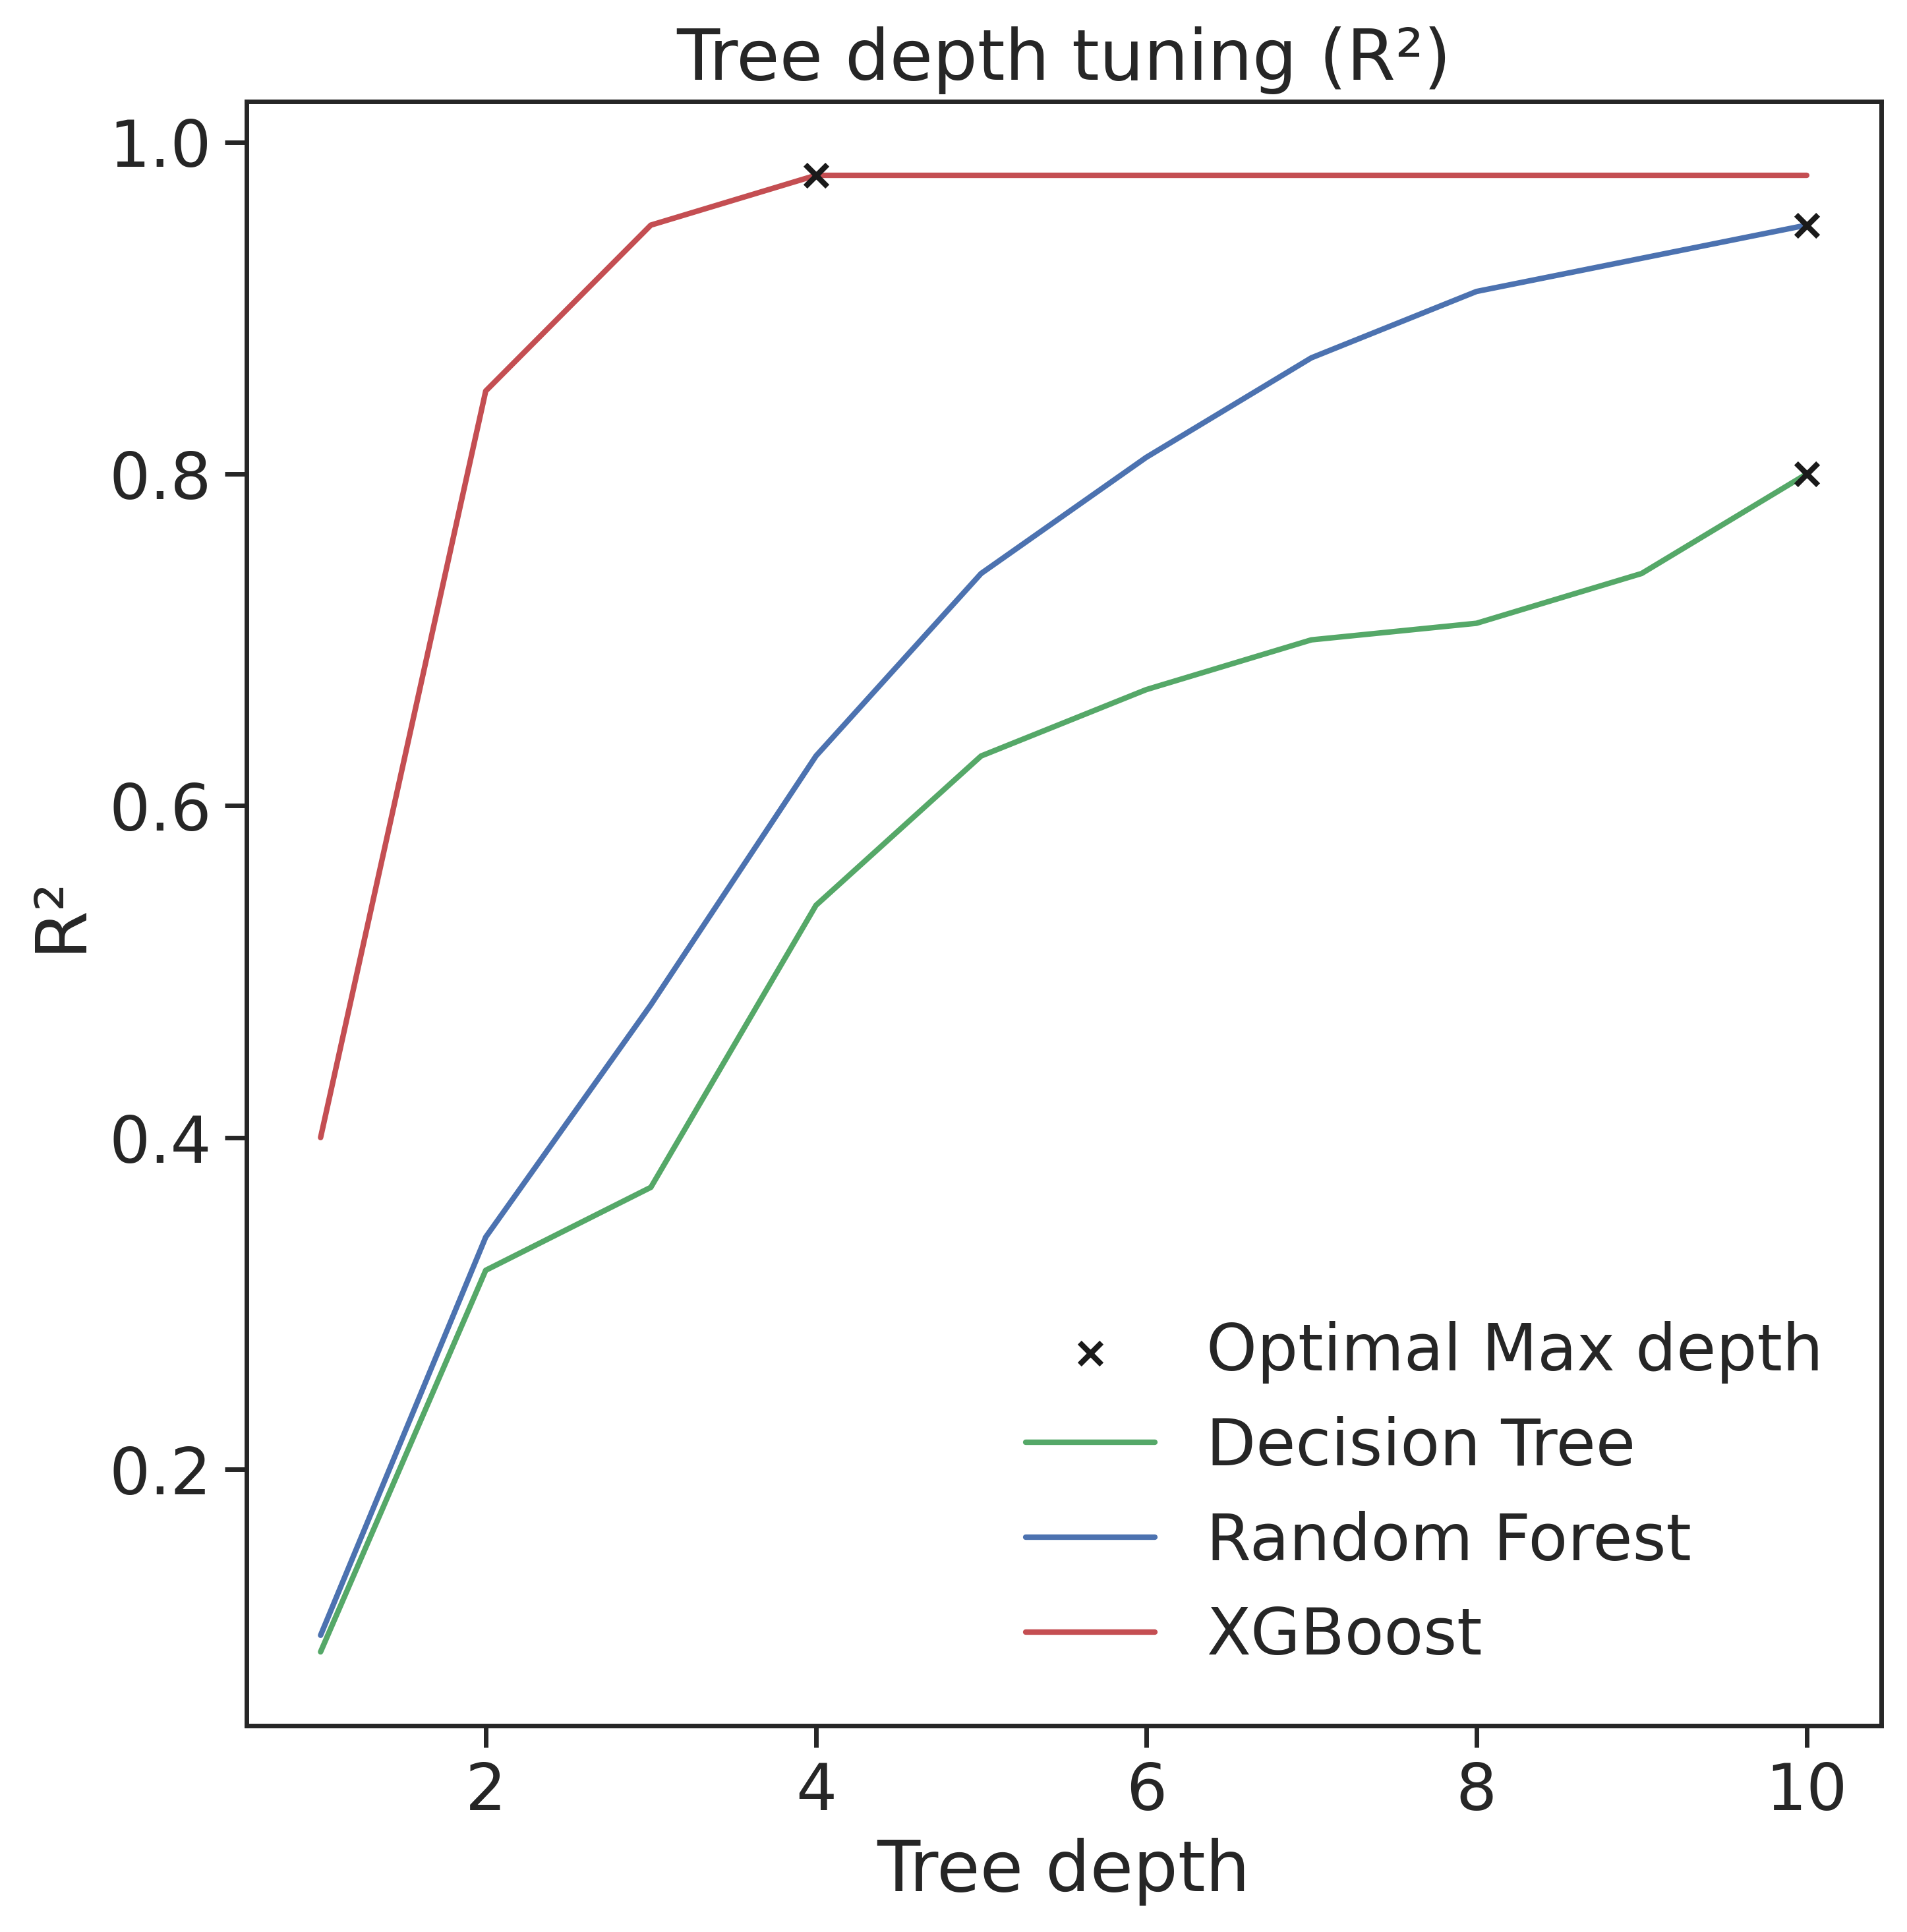

In [35]:
# Plot r2 graph
plt.rcParams['figure.figsize'] = (8, 8)
x_used = [10, 10, 4,]
y_used = [0.8, 0.95, 0.98]
plt.scatter(x_used, y_used, c='k', marker='x', label='Optimal Max depth', zorder=2)
line1 = plt.plot(max_depths, r2DT_results, 'g', label='Decision Tree', zorder=1)
line2 = plt.plot(max_depths, r2RF_results, 'b', label='Random Forest', zorder=1)
line3 = plt.plot(max_depths, r2XG_results, 'r', label='XGBoost', zorder=1)

plt.ylabel('R²')
plt.xlabel('Tree depth')
leg = plt.legend()
leg.get_frame().set_linewidth(0.0)
plt.title("Tree depth tuning (R²)")

plt.savefig('results/depthTreeTuning_R2.png')
plt.show()

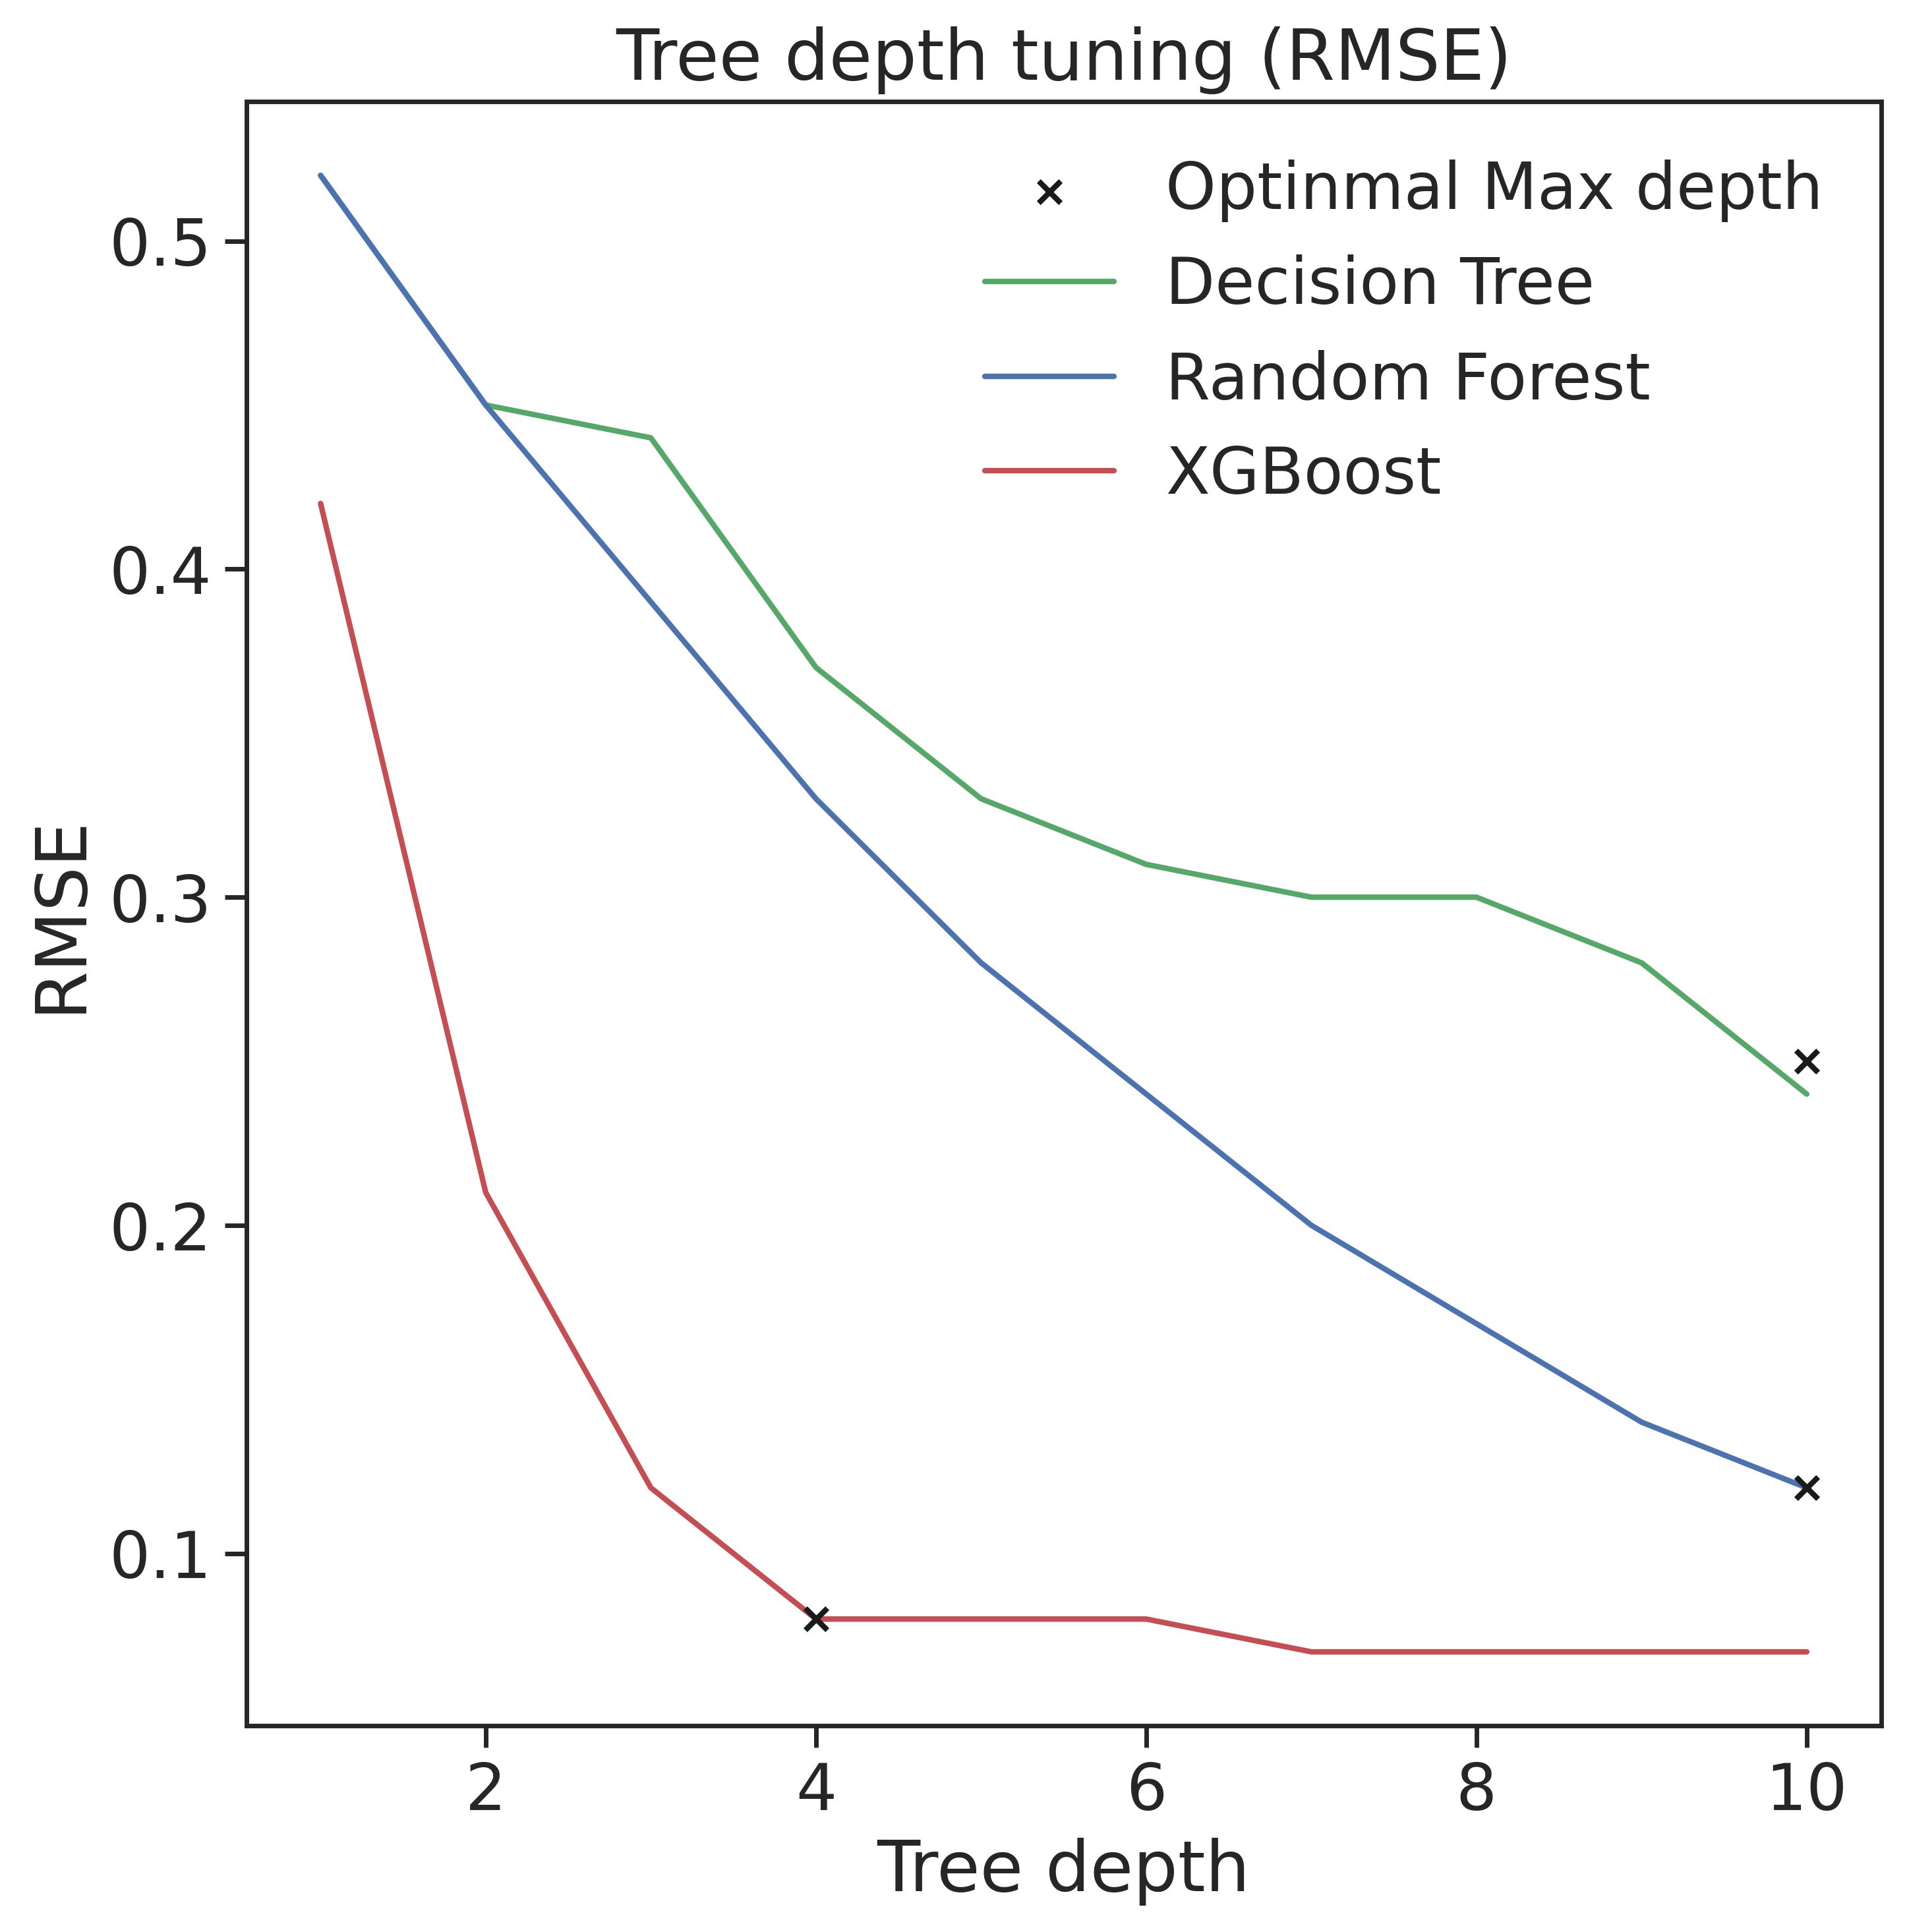

In [36]:
# Plot r2 graph
plt.rcParams['figure.figsize'] = (8, 8)
x_used = [10, 10, 4,]
y_used = [0.25, 0.12, 0.08]
plt.scatter(x_used, y_used, c='k', marker='x', label='Optinmal Max depth', zorder=2)
line1 = plt.plot(max_depths, rmseDT_results, 'g', label='Decision Tree', zorder=1)
line2 = plt.plot(max_depths, rmseRF_results, 'b', label='Random Forest', zorder=1)
line3 = plt.plot(max_depths, rmseXG_results, 'r', label='XGBoost', zorder=1)

plt.ylabel('RMSE')
plt.xlabel('Tree depth')
leg = plt.legend()
leg.get_frame().set_linewidth(0.0)
plt.title("Tree depth tuning (RMSE)")



plt.savefig('results/depthTreeTuning_RMSE.png')
plt.show()